In [1]:
# Some imports, not really important what they do

import pandas            as pd
import matplotlib.pyplot as plt
import numpy             as np

import matplotlib
import sys
import pickle
import itertools

sys.path.append('/home/usc/ie/dcr/hk/ambe_analysis')

# Import Diego's tools
from paquetes.npz_to_df import truehits_info_to_df
from paquetes.npz_to_df import track_info_to_df
from paquetes.npz_to_df import simple_track_info_to_df
from paquetes.npz_to_df import digihits_info_to_df

from paquetes.plotting import plot3d_digihits
from paquetes.plotting import unwrapped_cylinder_digihits

from cher_scint_characterization.first import neutronEnergySpectrum
from cher_scint_characterization.first import gammaEnergySpectrum
from cher_scint_characterization.first import nCaptureNumber
from cher_scint_characterization.first import digiHitsNumber
from cher_scint_characterization.first import eventsWithDigihits
from cher_scint_characterization.first import electrons_from_Scintillation
from cher_scint_characterization.first import real_scintillation_electrons
from cher_scint_characterization.first import scintillation_info
from cher_scint_characterization.first import electrons_from_Cherenkov
from cher_scint_characterization.first import real_cherenkov_electrons
from cher_scint_characterization.first import anyCherenkov_info
from cher_scint_characterization.first import nCapture_Cherenkov_info
from cher_scint_characterization.first import plot_light
from cher_scint_characterization.first import output_reconstruction_variables
from cher_scint_characterization.first import output_background_variables
from cher_scint_characterization.first import writeTriggerTimesPDF

from matplotlib.backends.backend_pdf import PdfPages

from tqdm  import tqdm
from scipy.optimize import fsolve

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)

%load_ext autoreload
%autoreload 2


#sys.path.append("/Users/diiego/Library/Mobile Documents/com~apple~CloudDocs/Desktop/DIEGO_cloud/USC/PHD/HK/HK SOURCES/code/ambe_source/npz_ana/cher_scint_characterization")
# Path to Diego's tools that we use here to extract data from the .npz file. This is needed in order to create the DataFrames (DFs)

In [2]:
# Wider Cells
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [3]:
# Path to the npz file in our machine

npz = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/nicfVec_0kHzDR_7Th200ns-400+950.npz'
# npz = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/500MeVelectron_0HzDR.npz'
# npz = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/npz/0MeVONLYDARKNOISE_5HzDR00-950_9Th200ns-400+950.npz'

threshold = 0
sfm       = 0
nevents   = 30000

In [4]:
# Creation of the DataFrames
# Creation of the hits DataFrame using the function truehits_info_to_df from Diego's tools
df_trueHits = truehits_info_to_df(npz)

# Creation of a simple tracks DataFrame, hopefully, lighter and less computationally challenging
df_simple_track = simple_track_info_to_df(npz)

# Creation of the DigiHits DataFrame using the function digihits_info_to_df
df_digiHits = digihits_info_to_df(npz, nevents)

NameError: name 'truehits_info_to_df' is not defined

In [ ]:
# Print the first DF (please note this is just first event and we are removing the DarkRate hits, also sorting by hit parent trackID)
df_trueHits[(df_trueHits['event_id'] == 1)].sort_values('true_hit_parent').head()

event_id true_hit_parent true_hit_pmt                 true_hit_time   
1         1               8         1801                      7.765455  \
1         1               8         1799                      8.232579   
1         1               8         1358                      9.001183   
1         1               8          945                     20.879158   
1         1              82         1211  67162911906979751437271040.0   

            true_hit_start_time       hit_x       hit_y       hit_z   
1                      1.787652   -9.493324  133.785828   102.50499  \
1                      1.786796  -20.027983   136.10965  116.247482   
1                      1.782995  103.841759   91.867622  114.848816   
1                      1.786635   13.374069 -133.882904   48.249874   
1  67162911906979751437271040.0  -13.363197 -133.992752 -106.001869   

  hit_start_x hit_start_y hit_start_z true_hit_creatorProcess       hit_r   
1   -9.631024   11.197912    59.55127                Cerenkov  168.807712  \
1   -9.627121   11.182592   59.549133                Cerenkov  180.112282   
1   -9.657874   11.107439    59.48719                Cerenkov  180.036167   
1    -9.62637   11.179647   59.548717                Cerenkov  142.938966   
1   22.201487    -32.0457  -42.790886                Cerenkov  171.373945   

   hit_start_r  
1    61.355550  
1    61.350070  
1    61.281119  
1    61.349012  
1    57.886897

In [ ]:
df_simple_track[(df_simple_track['event_id'] == 1)][2:].sort_values('track_id').head()

event_id track_pid track_id track_parent track_creator_process   
1         1        22        1            0               initial  \
1         1        22        2            0               initial   
1         1        22        3            0               initial   
1         1        22        4            0               initial   
1         1        22        5            0               initial   

  track_energy                      track_ti track_ri   track_rf  
1     1.496841                           0.0      8.0   80.60601  
1      0.46301  67162911906979751437271040.0      8.0  28.566513  
1     0.106074  67162911906979751437271040.0      8.0  47.318707  
1     0.763449  67162911906979751437271040.0      8.0  52.038292  
1     0.583188  67162911906979751437271040.0      8.0  46.858181

In [ ]:
df_digiHits[df_digiHits['event_id'] == 3]

Empty DataFrame
Columns: [event_id, digi_hit_pmt, digi_hit_charge, digi_hit_time, digi_hit_trigger, digi_hit_x, digi_hit_y, digi_hit_z, digi_hit_truehit_parent_trackID, digi_hit_truehit_creator, digi_hit_truehit_times, digi_hit_r]
Index: []

In [ ]:
# Agrupa por 'event_id' y cuenta el número de entradas por evento
event_counts = df_digiHits.groupby('event_id').size()
len(event_counts)

871

# DigiHits: DarkNoise vs. Real

In [ ]:
darkNoiseHits = []
for i in range(nevents):
    temp_df = df_digiHits[df_digiHits['event_id'].values == i]
    counter = 0
    
    if len(temp_df) > 0:
        for j in temp_df['digi_hit_truehit_creator']:
            if 'darkNoise' in j:
                counter += 1
        darkNoiseHits.append(counter)

In [ ]:
actual_hits = []
for i in range(nevents):
    temp_df = df_digiHits[df_digiHits['event_id'].values == i]
    counter = 0
    
    if len(temp_df) > 0:
        for j in temp_df['digi_hit_truehit_creator']:
            if 'darkNoise' not in j:
                counter += 1
        actual_hits.append(counter)

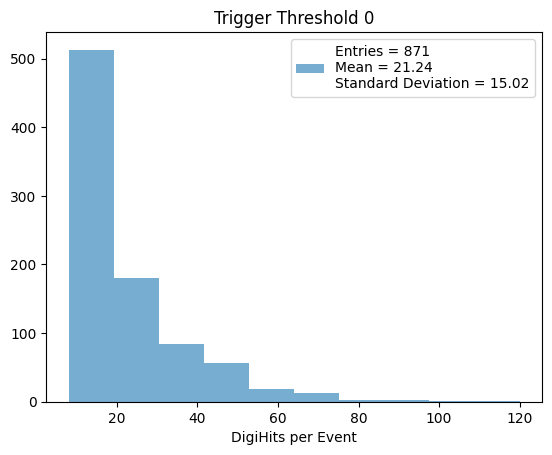

In [ ]:
#plt.hist(darkNoiseHits, alpha=0.6);
plt.hist(actual_hits, alpha=0.6);
plt.xlabel("DigiHits per Event");
#plt.yscale('log');
plt.title(f"Trigger Threshold {threshold}")

# Calcular estadísticas
# entries = len(darkNoiseHits)
# mean = np.mean(darkNoiseHits)
# std_dev = np.std(darkNoiseHits)

entries = len(actual_hits)
mean = np.mean(actual_hits)
std_dev = np.std(actual_hits)

# Crear la leyenda con las estadísticas
legend_text = (f'Entries = {entries}\n'
               f'Mean = {mean:.2f}\n'
               f'Standard Deviation = {std_dev:.2f}')

# Añadir la leyenda al gráfico
plt.legend([legend_text], loc='upper right');
#plt.savefig("./DarNoisePerEvent.png")

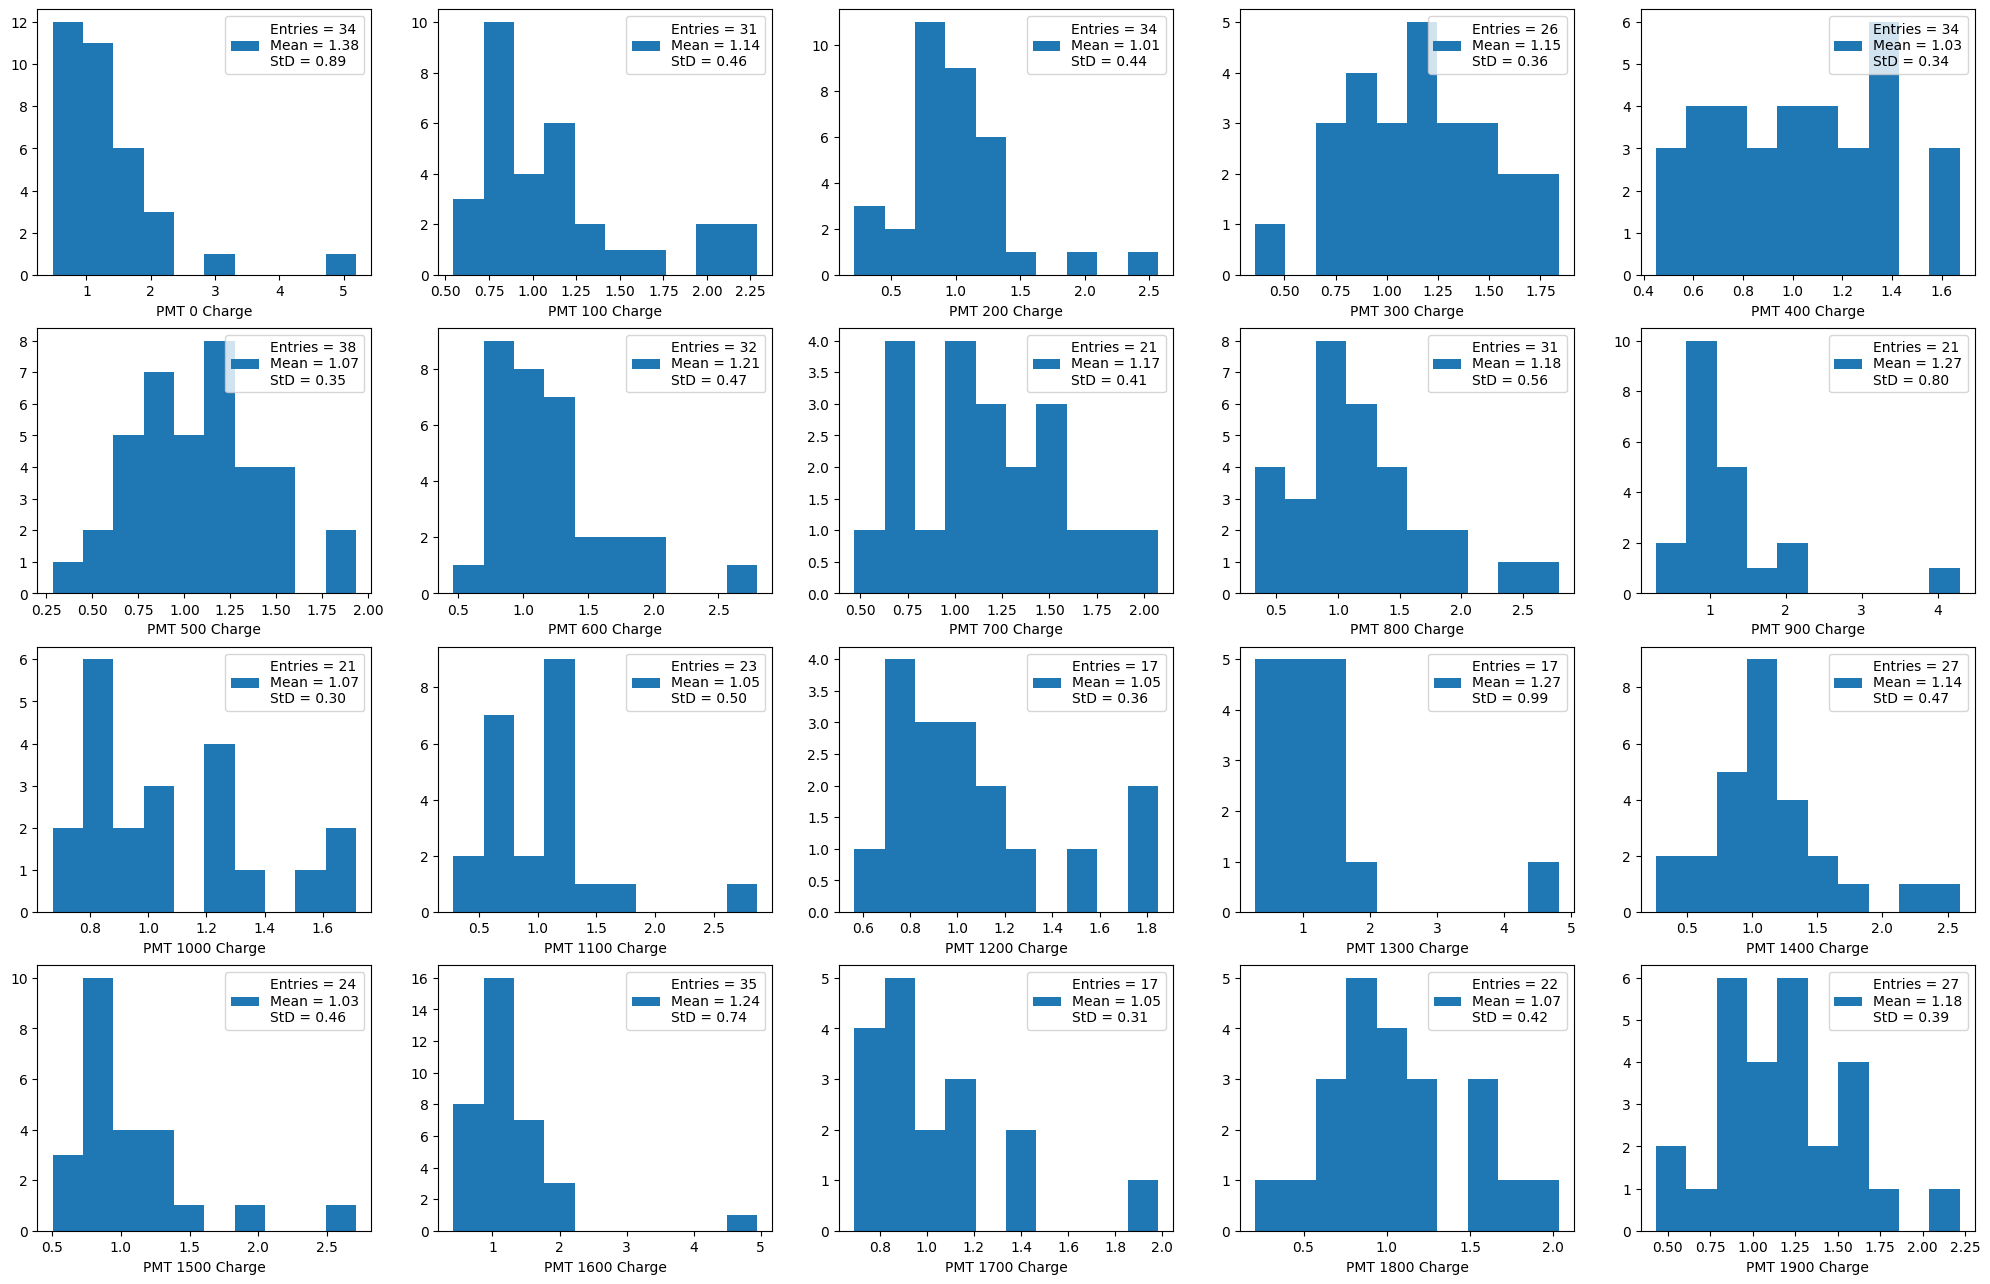

In [ ]:
fig = plt.figure(figsize=(25,20))

for i,j in zip(range(0, 2001, 100), range(1,21)):
    ax = fig.add_subplot(5, 5, j)

    data = df_digiHits[(df_digiHits['digi_hit_pmt'].values == i)]['digi_hit_charge']
    ax.hist(data);
    ax.set_xlabel("PMT {} Charge".format(i));
    
    # Calcular estadísticas
    entries = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)

    # Crear la leyenda con las estadísticas
    legend_text = (f'Entries = {entries}\n'
               f'Mean = {mean:.2f}\n'
               f'StD = {std_dev:.2f}')

    # Añadir la leyenda al gráfico
    ax.legend([legend_text], loc='upper right');


# plt.savefig("./PMTCharge.png")

In [ ]:
events = df_digiHits.groupby('event_id').size().index.values
counter = 0
PMTsWithMoreThanOneHit = []
hitsByPMT = []

for event in events:
    data = df_digiHits[df_digiHits['event_id'].values == event]['digi_hit_pmt'].values
    u, c = np.unique(data, return_counts=True)
    if len(u[c > 1]):
        
        print(f"In event {event} PMT {u[c > 1]} recorded {c[c>1]} DigiHits ")
        counter += 1
        PMTsWithMoreThanOneHit.append(len(u[c > 1]))
        
print(f"\nOnly {counter} events ({counter/len(df_digiHits.groupby('event_id').size())*100:.2f}% of the total) present PMTs with more than one DigiHit")
print(f"The average is {np.mean(PMTsWithMoreThanOneHit):.2f} PMTs with more than one DigiHit in these {counter} events")

In event 2919 PMT [1430] recorded [2] DigiHits 
In event 3419 PMT [131 1420] recorded [2 2] DigiHits 
In event 5178 PMT [376] recorded [2] DigiHits 
In event 5800 PMT [1337] recorded [2] DigiHits 
In event 5821 PMT [866] recorded [2] DigiHits 
In event 5863 PMT [751 1022] recorded [2 2] DigiHits 
In event 7036 PMT [108] recorded [2] DigiHits 
In event 13397 PMT [279] recorded [2] DigiHits 
In event 18038 PMT [836 1561] recorded [2 2] DigiHits 
In event 20313 PMT [307 704] recorded [2 2] DigiHits 
In event 20783 PMT [788] recorded [2] DigiHits 
In event 21375 PMT [1469 1501] recorded [2 2] DigiHits 
In event 23310 PMT [1161] recorded [2] DigiHits 
In event 24956 PMT [1751] recorded [2] DigiHits 
In event 25184 PMT [1860] recorded [2] DigiHits 
In event 25748 PMT [250 369] recorded [2 2] DigiHits 
In event 27297 PMT [1407] recorded [2] DigiHits 
In event 28502 PMT [171] recorded [2] DigiHits 
In event 28526 PMT [378] recorded [2] DigiHits 

Only 19 events (0.79% of the total) present PMT

# Hits Distribution

<IPython.core.display.Javascript object>


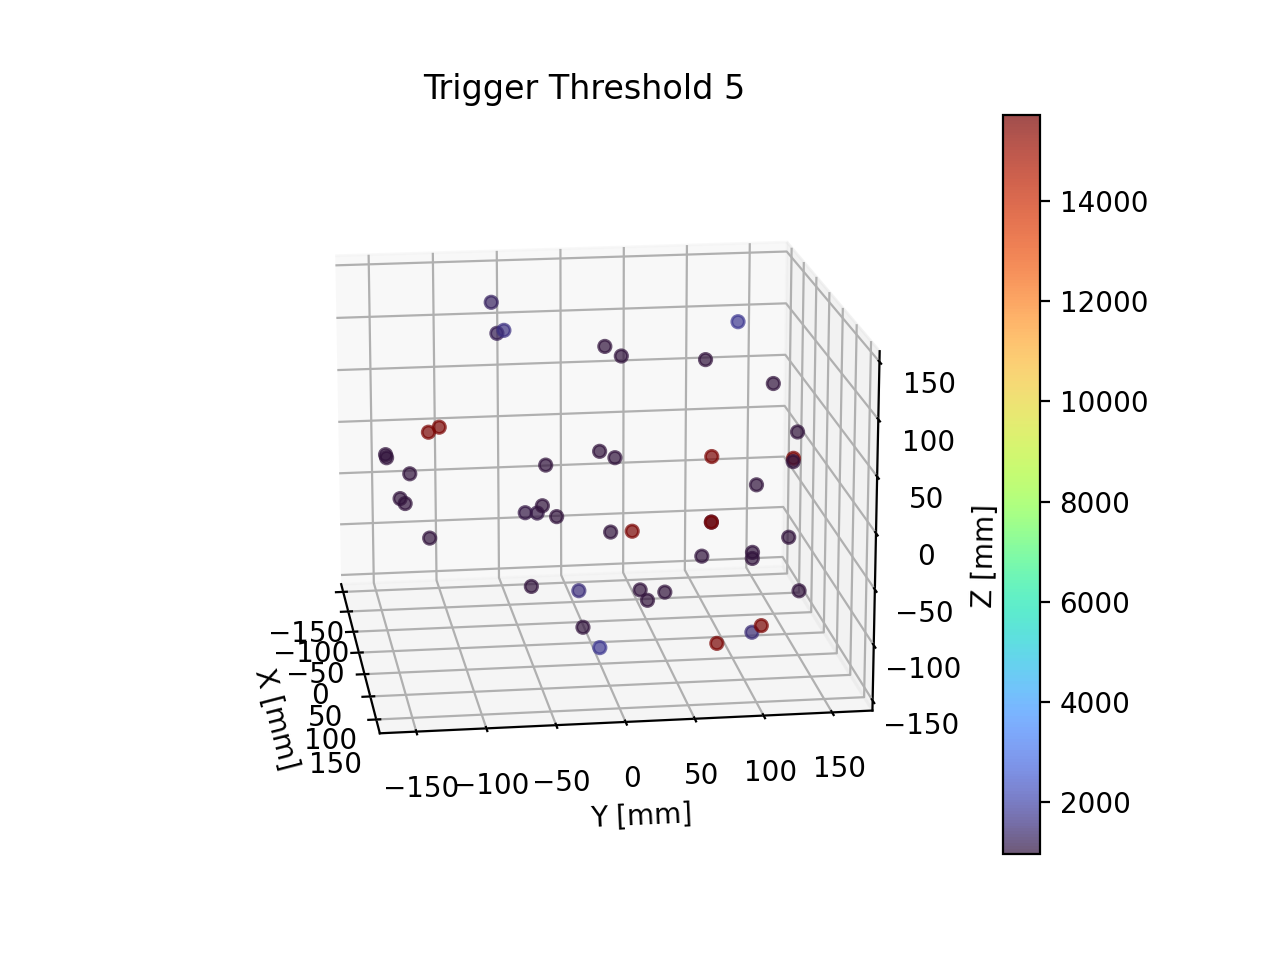

In [ ]:
%matplotlib notebook

plot3d_digihits(df_digiHits[(df_digiHits['event_id'] == 28526)], 'Trigger Threshold 5', colormap="turbo", alpha=0.7)

In [ ]:
nonZeroEvents = [i for i in range(nevents) if len(df_digiHits[(df_digiHits['event_id'] == i)]) > 0]

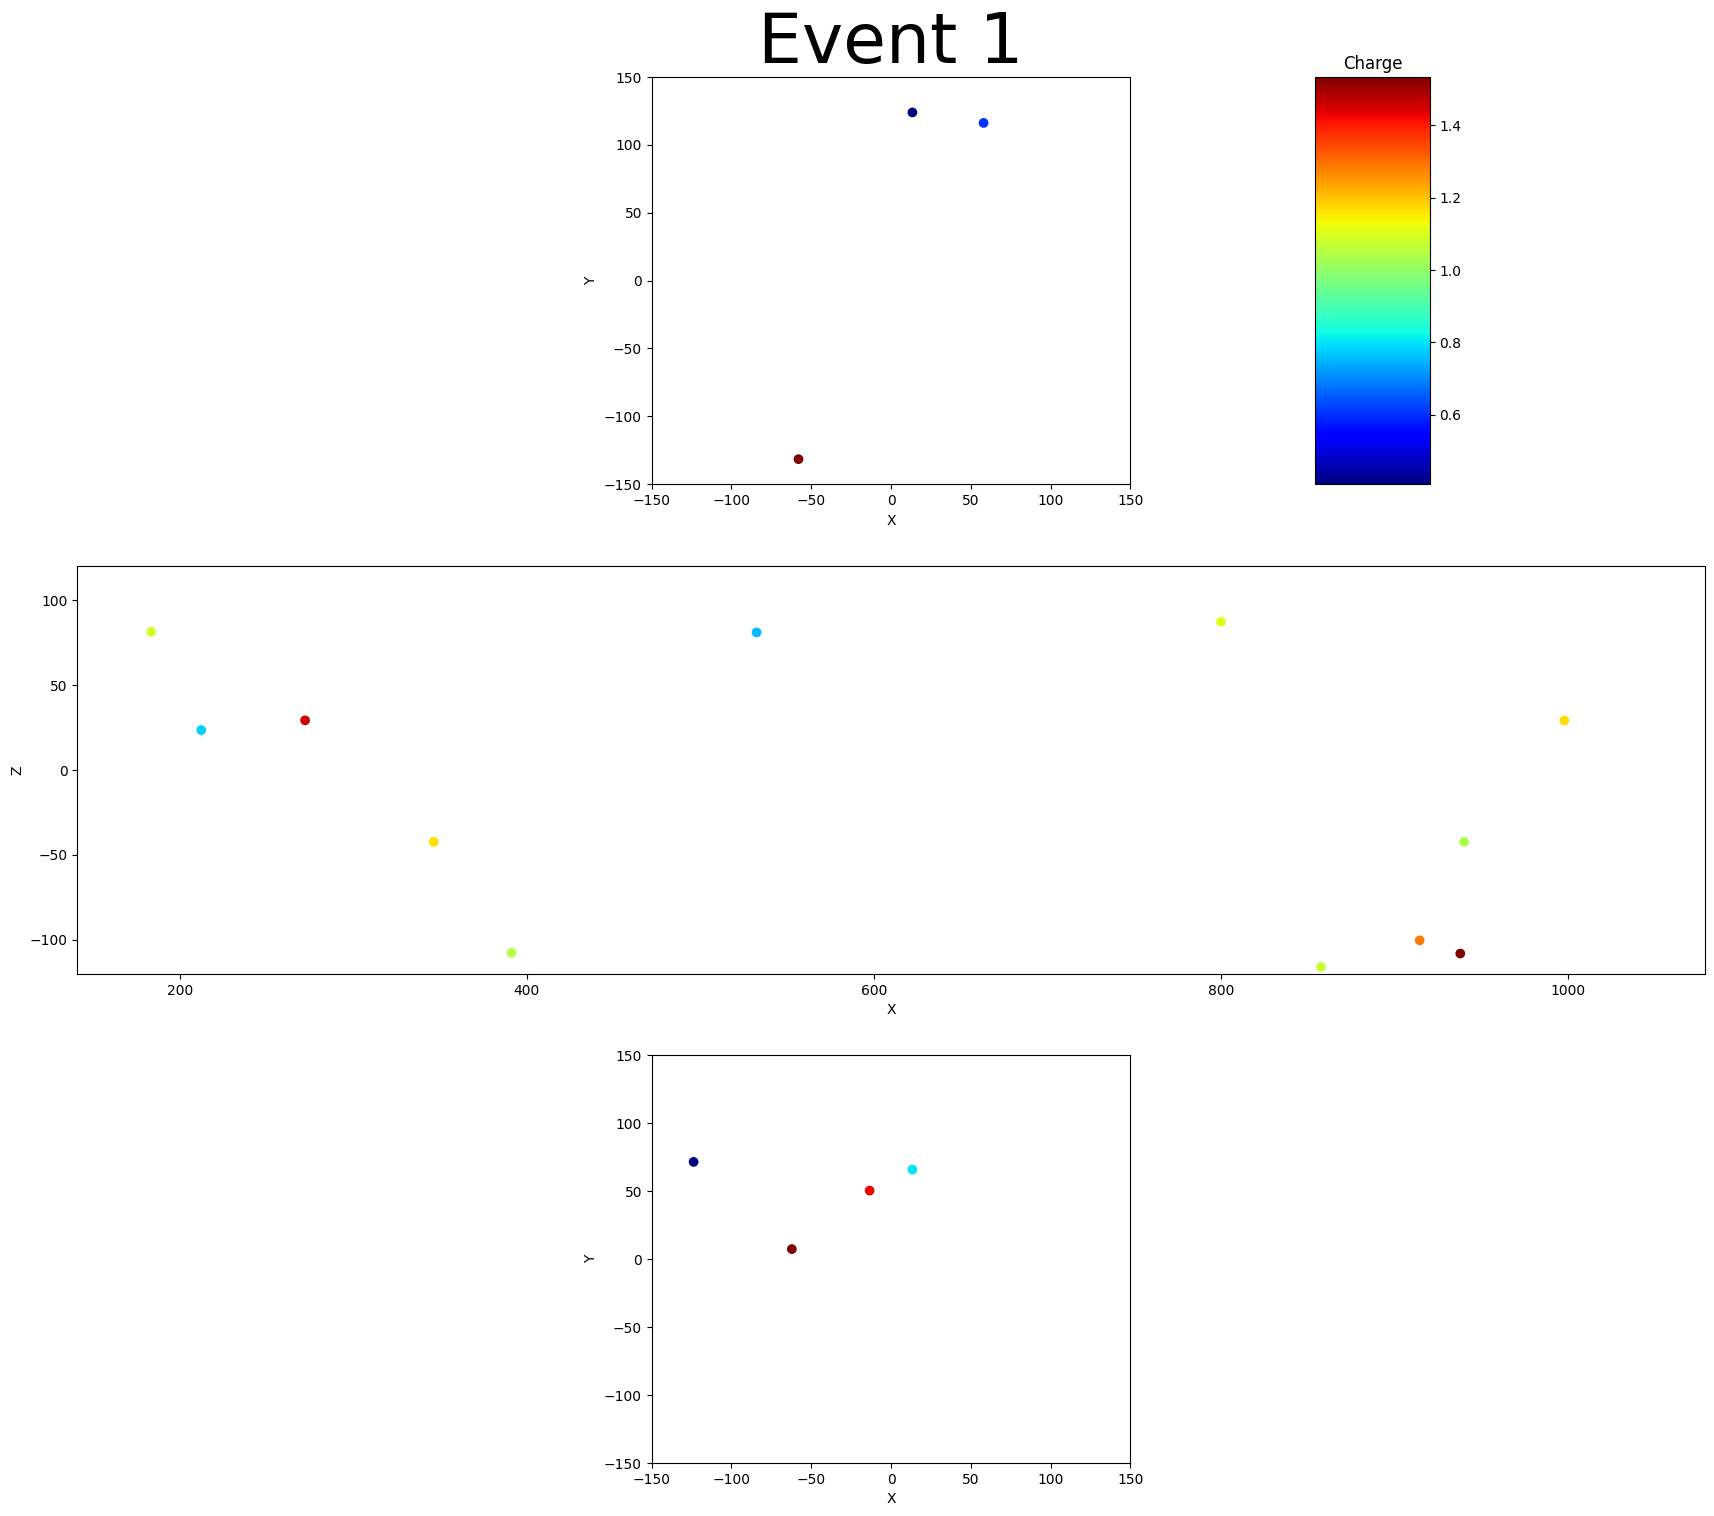

In [ ]:
unwrapped_cylinder_digihits(df_digiHits[(df_digiHits['event_id'] == 1)], title="Event 1", save=False)

# Hits Reconstruction 

This "circles" method is an easy approximation to a real vertex reconstruction of the interaction point. Basically, we are trying to find the center of every group of three hits, so, testing all possible combinations we find a preferred center: the center of the Cherenkov ring so every group of three hits that has this center is considered signal instead of background (Dark Noise).

Known limitations:
- We are just doing this for the hits in the barrel volume (leaving behind both upper and bottom lids).
- If the ring is produced in the section of the barrel where the unfolding is going to take place, this will not find the center of three points that lay in both sides of the unfolding correctly.

In [ ]:
def find_circle(p1, p2, p3):
    # Extracting coordinates
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    # System of equations to find the center (h, k)
    def equations(vars):
        h, k = vars
        eq1 = (x1 - h)**2 + (y1 - k)**2 - (x2 - h)**2 - (y2 - k)**2
        eq2 = (x2 - h)**2 + (y2 - k)**2 - (x3 - h)**2 - (y3 - k)**2
        return [eq1, eq2]

    # Initial guess for the center
    h0, k0 = np.mean([p1, p2, p3], axis=0)

    # Solve for the center (h, k)
    h, k = fsolve(equations, (h0, k0))

    # Calculate the radius
    r = np.sqrt((x1 - h)**2 + (y1 - k)**2)

    return h, k, r

# Function to plot the circle
def plot_circle(h, k, r, ax, label):
    theta = np.linspace(0, 2*np.pi, 100)
    x = h + r * np.cos(theta)
    y = k + r * np.sin(theta)
    ax.plot(x, y, alpha=0.5, label=label, linestyle='-.')

# Function to check if three points are collinear
def are_collinear(p1, p2, p3, tol=1e-9):
    # Calculate the area of the triangle formed by the points
    # If the area is close to zero, the points are collinear
    area = 0.5 * abs(p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1]))
    return area < tol

# Function to plot all possible circles for combinations of 3 points with error handling
def plot_all_circles_with_handling(points):
    centers = []
    fig, ax = plt.subplots(figsize=(8,15))
    ax.scatter(points[:, 0], points[:, 1], color='black', label='Points')

    # Generate all combinations of 3 points from the set
    combinations = list(itertools.combinations(range(len(points)), 3))

    # Plot each circle for each combination of 3 points
    for idx, (i, j, k) in enumerate(combinations):
        p1, p2, p3 = points[i], points[j], points[k]

        # Check if points are collinear before trying to compute the circle
        if are_collinear(p1, p2, p3):
            continue  # Skip if points are collinear

        try:
            h, k, r = find_circle(p1, p2, p3)
            plot_circle(h, k, r, ax, label=f'Circle {idx+1}')
            centers.append([p1, p2, p3, h,k])
        except Exception as e:
            # If fsolve fails, we catch the exception and skip to the next combination
            continue
    
    # Finalize the plot
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.set_ylim(-350, 350)
    # ax.set_xlim(0, 1200)
    ax.legend().remove()  # Too many circles for a clear legend
    plt.title('All Possible Circles through Combinations of 3 Points')
    plt.show()
    
    return centers

In [ ]:
df_digiHits.groupby('event_id').size().index[:10]

Index([1, 12, 18, 30, 32, 51, 52, 57, 69, 87], dtype='int32', name='event_id')

In [ ]:
event = 18
r = 168
x = np.float64(df_digiHits[df_digiHits['event_id'].values == event]['digi_hit_x'].values)
y = np.float64(df_digiHits[df_digiHits['event_id'].values == event]['digi_hit_z'].values)
z = np.float64(df_digiHits[df_digiHits['event_id'].values == event]['digi_hit_y'].values)

# Tranversal projection
theta = np.arctan2(y, x)
phi = theta + np.pi
x_proj = r * phi
y_proj = z

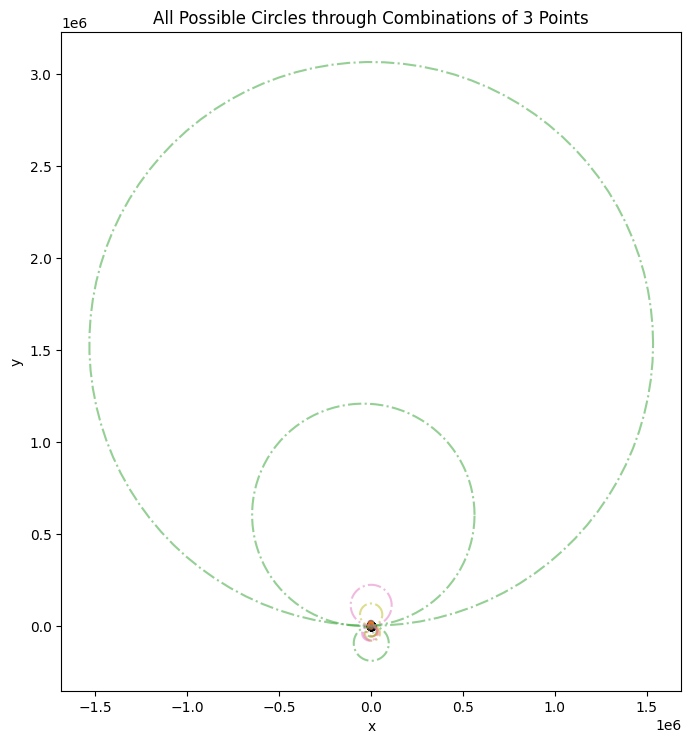

In [ ]:
data = np.array([(i,j) for (i,j) in zip(x_proj, y_proj)])

# Re-plot with error handling
centers = plot_all_circles_with_handling(data)

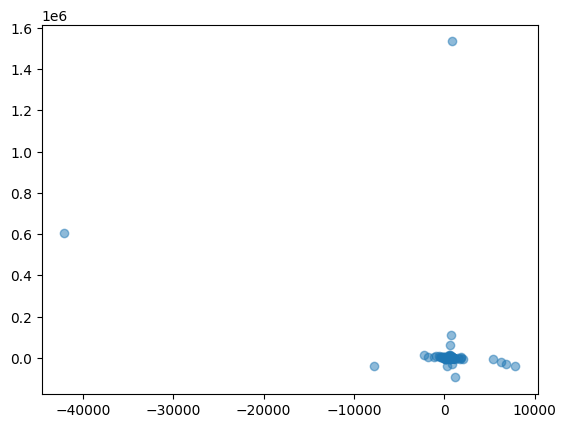

In [ ]:
x = [i[3] for i in centers]
y = [i[4] for i in centers]

plt.scatter(x,y, alpha=0.5);
# plt.xlim(-2000, 2000);
# plt.ylim(-5000, 6000);

In [ ]:
r = [np.sqrt(i**2 + j**2) for i,j in zip(x,y)]

mean   = np.mean(r)
seMean = np.std(r)/np.sqrt(len(r))

median   = np.median(r)
seMedian = 1.2533*seMean

In [ ]:
seMedian

3053.166188110434

In [ ]:
seMean

2436.101642153063

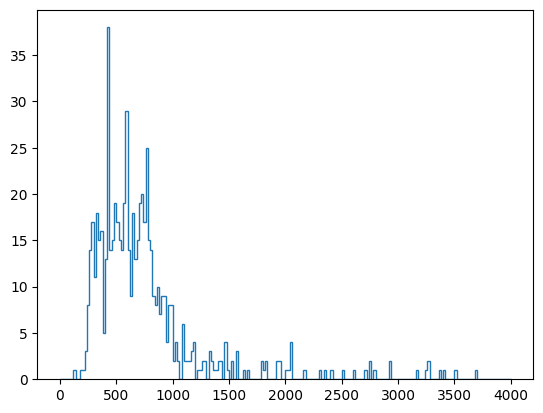

In [ ]:
plt.hist(r, bins=200, histtype="step", range=(0, 4000), label="centers");

#plt.vlines(mean-seMean,0,40, color="red", linestyle="-.", label="mean ± seMean");
#plt.vlines(mean+seMean,0,40, color="red", linestyle="-.");
#
#plt.vlines(median-seMedian,0,40, color="black", linestyle=":", label="median ± seMedian");
#plt.vlines(median+seMedian,0,40, color="black", linestyle=":");
#
#plt.legend(loc="upper right");

In [ ]:
indices = [i for i,v in enumerate(r) if v>median-5 and v<median+5]

In [ ]:
ccenters = [centers[i] for i in indices]

In [ ]:
ccenters[0][0]

array([407.21131426, 135.20785522])

In [ ]:
rX = []
rY = []

for i in ccenters:
    rX.append(i[0][0])
    rX.append(i[1][0])
    rX.append(i[2][0])
    rY.append(i[0][1])
    rY.append(i[1][1])
    rY.append(i[2][1])

In [ ]:
list(set(rX))

[439.87184933719857,
 386.60576293366165,
 579.4586059147643,
 868.8839684642239,
 747.9583258688593,
 61.41327330281742,
 407.2113142589366,
 571.5105886388537,
 668.1128132597778,
 445.3123880645703,
 415.7361115731338]

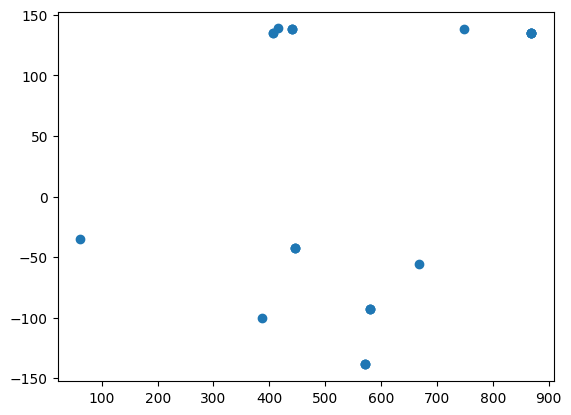

In [ ]:
plt.scatter(rX, rY);

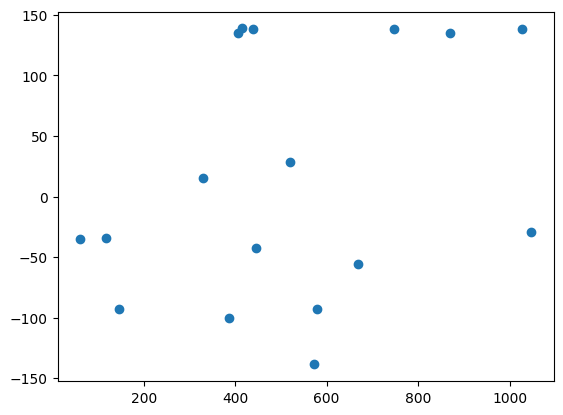

In [ ]:
plt.scatter(x_proj, y_proj);

# PMT Rate Produced By Ni Ball

### Prove that almost every PMT gets a SPE
This needs revision. For me, the fact that PMTs are getting just SPEs is that for every decay (event) every PMT is getting just one DigiHit. Is this true?

In [ ]:
npz = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/nicfVec_0kHzDR_7Th200ns-400+950.npz'
nevents   = 30000

# Creación del DataFrame de DigiHits usando la función digihits_info_to_df
df_digiHits = digihits_info_to_df(npz, nevents)

In [ ]:
actual_hits = []
counter = 0
print(len(np.unique(df_digiHits['event_id'])))
for i in np.unique(df_digiHits['event_id']):
    temp_df = df_digiHits[df_digiHits['event_id'].values == i]
    if len(temp_df['digi_hit_pmt']) == len(np.unique(temp_df['digi_hit_pmt'])):
        counter += 1
print(counter)

871
853


### Rate per PMT in the hole simulation
We compute how many DigiHits (i.e. SPEs) our PMTs get in our entire simulation (30k decays).

Then, we divide the average number of SPEs/PMT by the number of simulated decays and multiply it by our source's activity, getting the expected SPE frecuency on average per PMT.

We are doing this here taking into account the Trigger Threshold, you can find below the calculation done for the no trigger case, which is the more accurate calculation nowadays (Dec 2024).

Running through files: 100%|█████████████████████████████████████████████████████████████████████████████████████| 26/26 [02:39<00:00,  6.14s/TT]


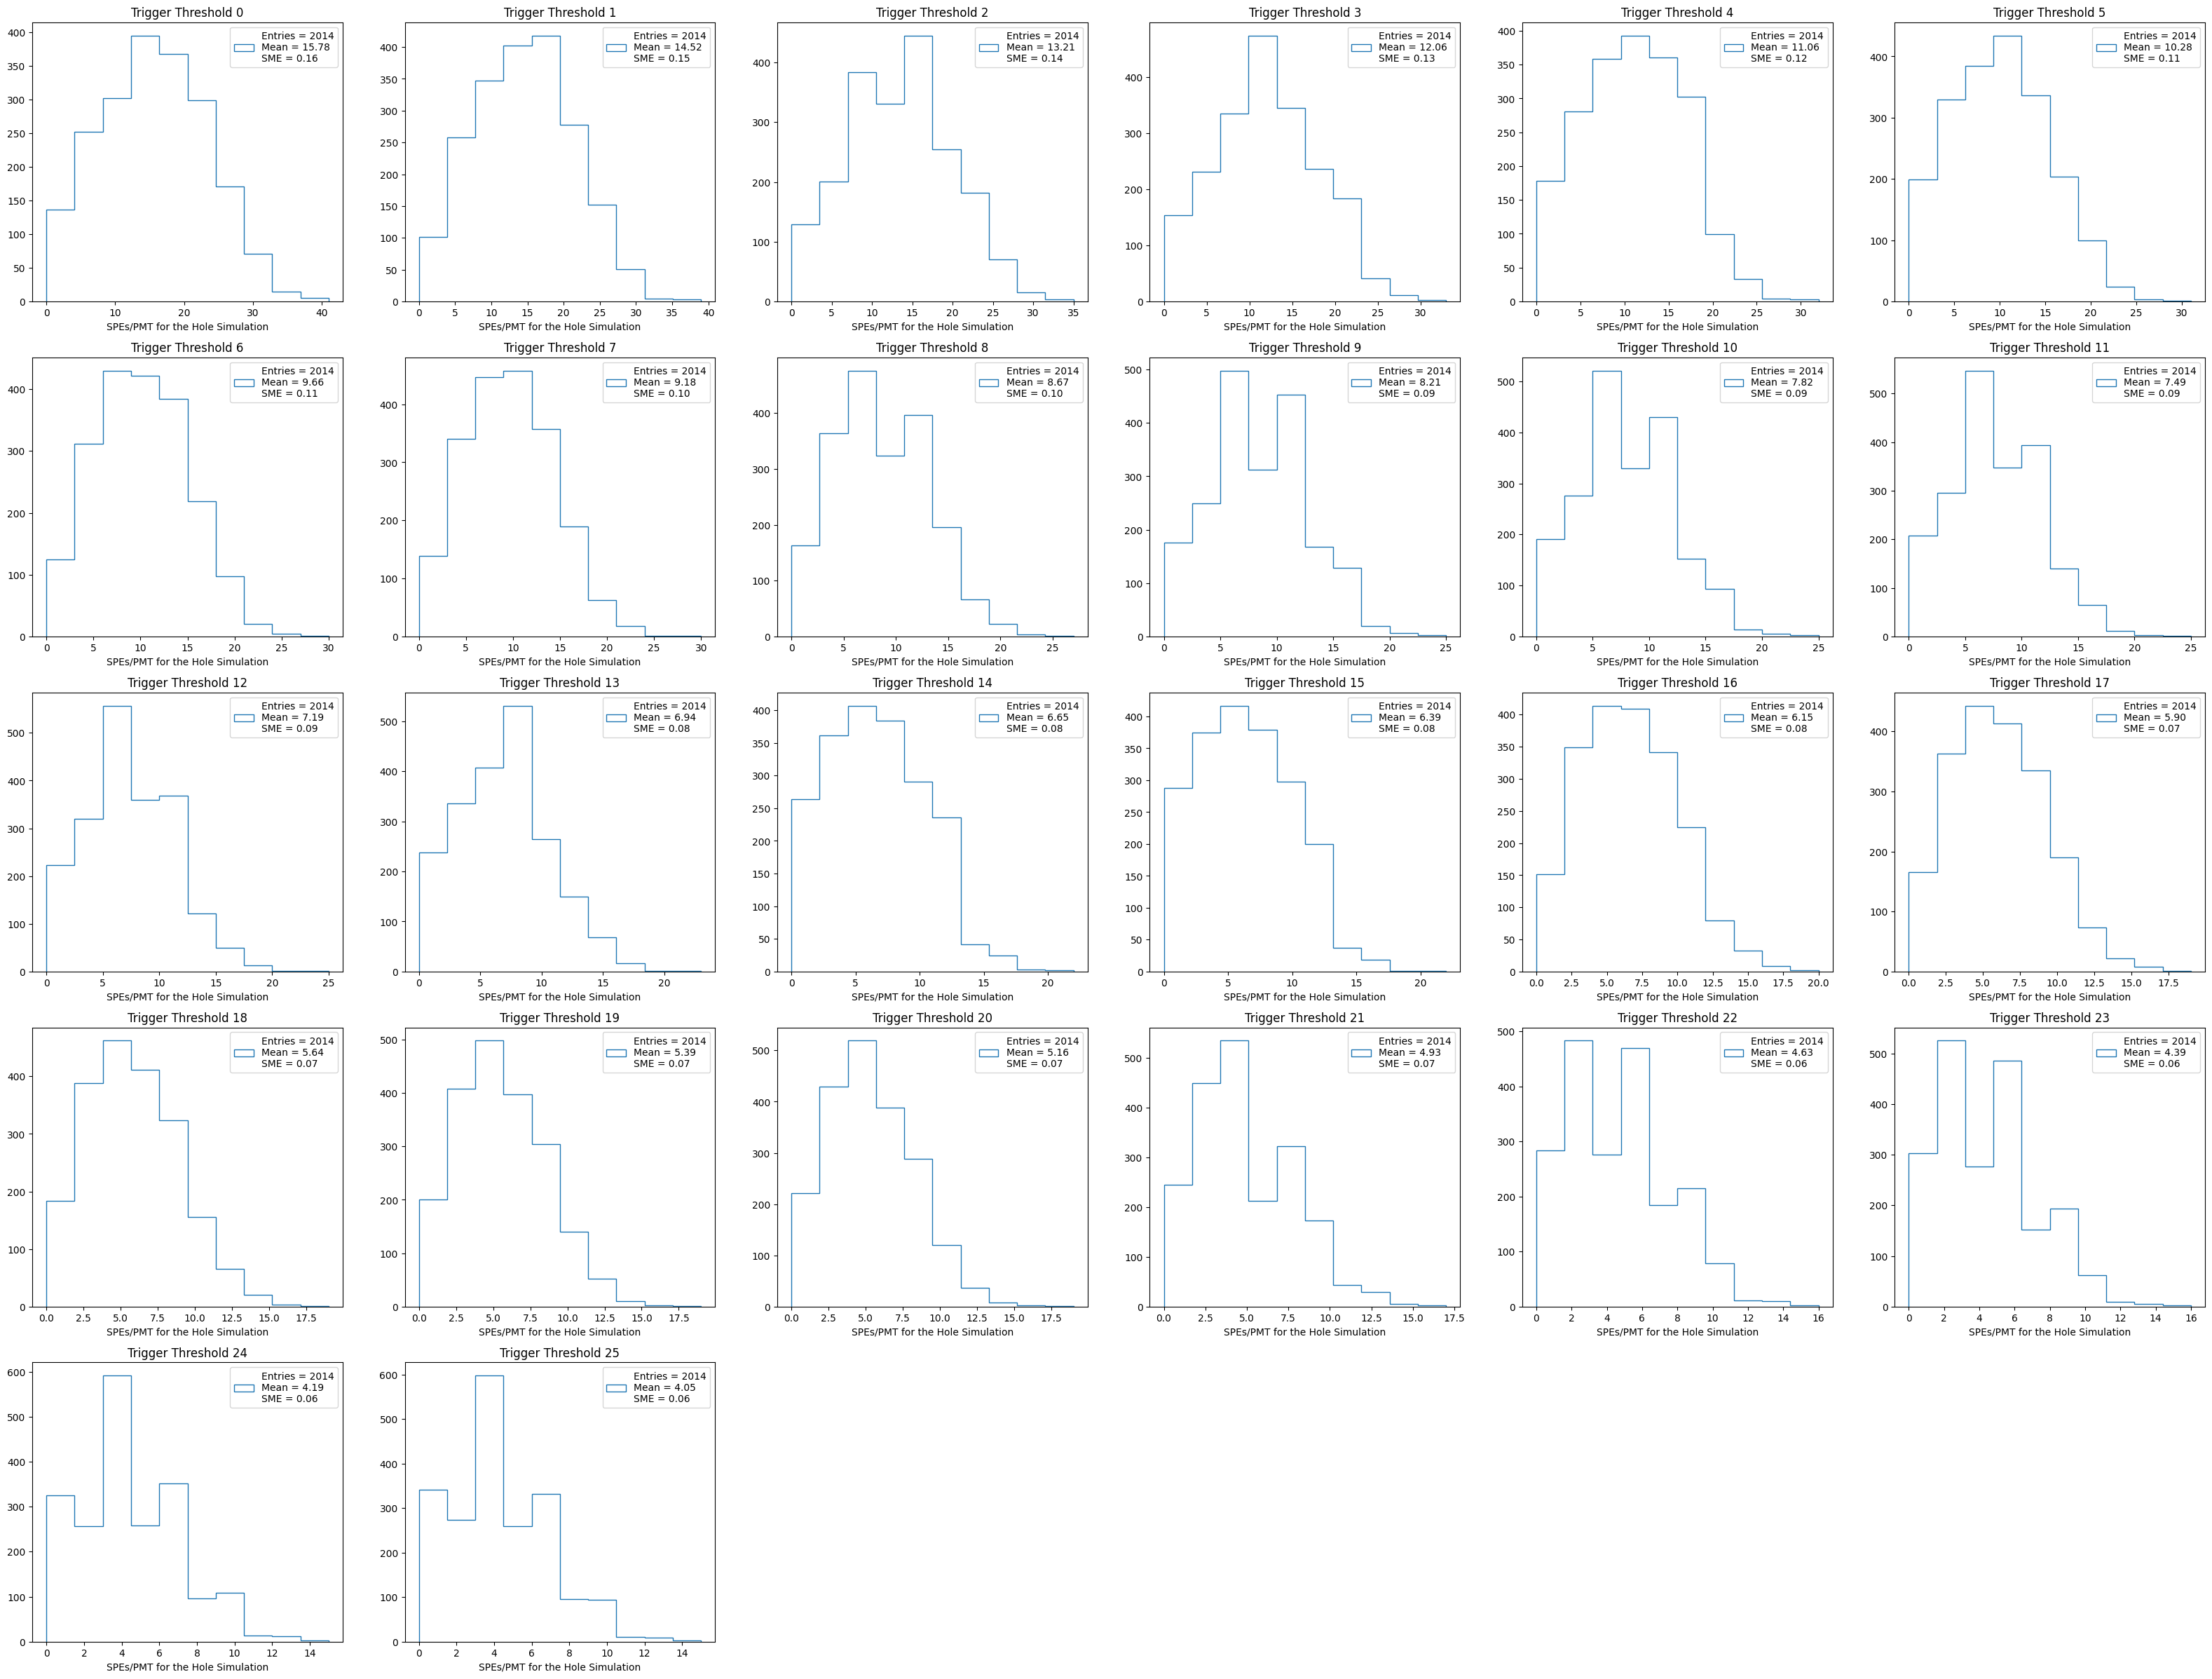

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(40, 30))
gs  = gridspec.GridSpec(5, 6, figure=fig)

rates     = []
rates_unc = []

for file_idx in tqdm(range(26), desc="Running through files", unit="TT", dynamic_ncols=True):  
    # Path to the npz file in our machine
    npz = f'/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/nicfVec_0kHzDR_{file_idx}Th200ns-400+950.npz'
    
    # Trigger Threshold and Number of events
    threshold   = file_idx
    nevents     = 30000

    # Creation of the DataFrame
    df_digiHits = digihits_info_to_df(npz, nevents)
    
    # Initialize Array
    pmt_counter = np.zeros(2014)

    # Iterate through number of decays
    for i in range(nevents):
        
        # Create a temporary DataFrame just holding the current decay info
        temp_df = df_digiHits[df_digiHits['event_id'].values == i]
        
        # If that decay is not empty, count what PMTs were hit and update pmt_counter
        if len(temp_df['digi_hit_pmt'].values) > 0:
            pmt_counter[temp_df['digi_hit_pmt'].to_list()] += 1
    
    # Plot Histogram
    ax = fig.add_subplot(gs[file_idx])
    
    ax.hist(pmt_counter, histtype="step")
    ax.set_xlabel("SPEs/PMT for the Hole Simulation")
    ax.set_title(f"Trigger Threshold {threshold}")

    # Compute Statistics
    entries = len(pmt_counter)
    mean    = np.mean(pmt_counter)
    std_dev = np.std(pmt_counter)
    
    # Save the rate and its uncertainty
    rates.append(mean)
    rates_unc.append(std_dev/np.sqrt(entries))

    # Legend
    legend_text = (f'Entries = {entries}\n'
                   f'Mean = {mean:.2f}\n'
                   f'SME = {std_dev/np.sqrt(entries):.2f}')

    ax.legend([legend_text], loc='upper right')

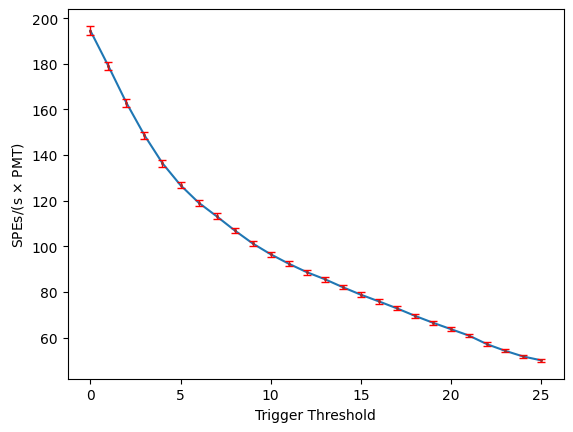

In [ ]:
rates_per_second     = [i/30000*3.7e5 for i in rates]
rates_per_second_unc = [i/30000*3.7e5 for i in rates_unc]

plt.plot(range(26), rates_per_second);
plt.errorbar(range(26), rates_per_second, yerr=rates_per_second_unc, fmt='s', markersize=1, color='brown', ecolor='red', elinewidth=1, capsize=3);
plt.xlabel("Trigger Threshold");
plt.ylabel(r"SPEs/(s $\times$ PMT)");

### Calculation With No Trigger

In [4]:
npz = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/npz/nicfVec_0kHzDR_NOTRIGGER.npz'
nevents   = 30000

# Creación del DataFrame de DigiHits usando la función digihits_info_to_df
df_digiHits = digihits_info_to_df(npz, nevents)

In [5]:
pmt_counter = np.zeros(2014)

# Iterate through number of decays
for i in tqdm(range(nevents)):

    # Create a temporary DataFrame just holding the current decay info
    temp_df = df_digiHits[df_digiHits['event_id'].values == i]

    # If that decay is not empty, count what PMTs were hit and update pmt_counter
    if len(temp_df['digi_hit_pmt'].values) > 0:
        pmt_counter[temp_df['digi_hit_pmt'].to_list()] += 1

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:05<00:00, 5866.42it/s]


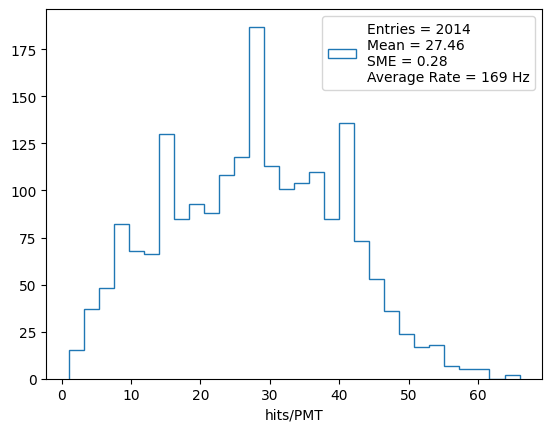

In [8]:
plt.hist(pmt_counter, bins=30, histtype='step');
plt.xlabel("hits/PMT");

entries = len(pmt_counter)
mean = np.mean(pmt_counter)
std_dev = np.std(pmt_counter)

# Crear la leyenda con las estadísticas
legend_text = (f'Entries = {entries}\n'
               f'Mean = {mean:.2f}\n'
               f'SME = {std_dev/np.sqrt(entries):.2f}\n'
               f'Average Rate = {round(mean/30000*1.85e5)} Hz')

# Añadir la leyenda al gráfico
plt.legend([legend_text], loc='upper right');

### Average rate is 339 Hz, but for the PMT that sees the maximum number of SPEs, the rate can be up to 814 Hz and for the one that see the least, 12 Hz.

# Analysis of FD PMT Rates From Aurora

In [ ]:
df = pd.read_csv("./WCTE-PMT dark rates-20241104-092734-20241104-133705.csv")

In [ ]:
len(df.columns)

62

In [ ]:
# Read Data
fd_df = pd.read_csv("./Ratemeter-mPMT04-20241204-093654-20241204-133654.csv")
noise = pd.read_csv("./Ratemeter-mPMT04-20241204-161405-20241204-164748.csv")

# Rename Columns
new_cols = []
for i in range(19):
    new_cols.append(f"Time_CH{i+1}")
    new_cols.append(f"CH{i+1}")
    
fd_df.columns = new_cols
noise.columns = new_cols

def CET_to_unix(local_time_str):
    # Definir la zona horaria CET
    cet_timezone = pytz.timezone("Europe/Madrid")

    # Convertir la hora local a un objeto datetime
    local_time = datetime.datetime.strptime(local_time_str, "%d-%m-%Y %H:%M:%S")

    # Localizar la hora en CET (incluye ajuste de horario de verano si es necesario)
    local_time = cet_timezone.localize(local_time)

    # Convertir a Unix time
    unix_time = int(local_time.timestamp())
    
    return unix_time

In [ ]:
fd_df.head()

Time_CH1   CH1    Time_CH2   CH2    Time_CH3   CH3    Time_CH4   CH4   
0  1733301415  1840  1733301415  2317  1733301415  1465  1733301415  2875  \
1  1733301417  1729  1733301417  2245  1733301417  1504  1733301417  2660   
2  1733301419  1750  1733301419  2255  1733301419  1401  1733301419  2648   
3  1733301421  1728  1733301421  2099  1733301421  1321  1733301421  2620   
4  1733301423  1741  1733301423  2214  1733301423  1457  1733301423  2608   

     Time_CH5   CH5    Time_CH6   CH6    Time_CH7   CH7    Time_CH8   CH8   
0  1733301415  2120  1733301415  2533  1733301415  2240  1733301415  1835  \
1  1733301417  1967  1733301417  2538  1733301417  2223  1733301417  1660   
2  1733301419  1969  1733301419  2543  1733301419  2185  1733301419  1739   
3  1733301421  1926  1733301421  2373  1733301421  2030  1733301421  1641   
4  1733301423  1963  1733301423  2551  1733301423  2117  1733301423  1616   

     Time_CH9   CH9   Time_CH10  CH10   Time_CH11  CH11   Time_CH12  CH12   
0  1733301415  1375  1733301415  1790  1733301415  1515  1733301415  1374  \
1  1733301417  1343  1733301417  1670  1733301417  1434  1733301417  1444   
2  1733301419  1213  1733301419  1623  1733301419  1465  1733301419  1381   
3  1733301421  1226  1733301421  1620  1733301421  1321  1733301421  1298   
4  1733301423  1315  1733301423  1685  1733301423  1405  1733301423  1305   

    Time_CH13  CH13   Time_CH14  CH14   Time_CH15  CH15   Time_CH16  CH16   
0  1733301415  1953  1733301415  1661  1733301415  1884  1733301415  2427  \
1  1733301417  1952  1733301417  1584  1733301417  1835  1733301417  2408   
2  1733301419  1918  1733301419  1578  1733301419  1829  1733301419  2398   
3  1733301421  1823  1733301421  1542  1733301421  1805  1733301421  2345   
4  1733301423  1935  1733301423  1536  1733301423  1782  1733301423  2409   

    Time_CH17  CH17   Time_CH18  CH18   Time_CH19  CH19  
0  1733301415  1745  1733301415  1755  1733301415  1752  
1  1733301417  1787  1733301417  1620  1733301417  1726  
2  1733301419  1801  1733301419  1638  1733301419  1635  
3  1733301421  1664  1733301421  1598  1733301421  1600  
4  1733301423  1647  1733301423  1585  1733301423  1661

In [ ]:
noise.head()

Time_CH1   CH1    Time_CH2   CH2    Time_CH3   CH3    Time_CH4   CH4   
0  1733255380  1483  1733255380  1794  1733255380  1204  1733255380  2018  \
1  1733255382  1385  1733255382  1773  1733255382  1155  1733255382  2007   
2  1733255384  1419  1733255384  1798  1733255384  1198  1733255384  2087   
3  1733255386  1394  1733255386  1722  1733255386  1138  1733255386  2007   
4  1733255388  1472  1733255388  1757  1733255388  1132  1733255388  2050   

     Time_CH5   CH5    Time_CH6   CH6    Time_CH7   CH7    Time_CH8   CH8   
0  1733255380  1578  1733255380  1962  1733255380  1595  1733255380  1328  \
1  1733255382  1503  1733255382  2009  1733255382  1551  1733255382  1287   
2  1733255384  1452  1733255384  1901  1733255384  1517  1733255384  1209   
3  1733255386  1486  1733255386  1893  1733255386  1581  1733255386  1249   
4  1733255388  1469  1733255388  1976  1733255388  1487  1733255388  1295   

     Time_CH9   CH9   Time_CH10  CH10   Time_CH11  CH11   Time_CH12  CH12   
0  1733255380  1051  1733255380  1344  1733255380  1190  1733255380  1108  \
1  1733255382   987  1733255382  1331  1733255382  1179  1733255382  1052   
2  1733255384  1046  1733255384  1235  1733255384  1180  1733255384  1039   
3  1733255386   995  1733255386  1305  1733255386  1160  1733255386  1019   
4  1733255388  1020  1733255388  1214  1733255388  1193  1733255388  1071   

    Time_CH13  CH13   Time_CH14  CH14   Time_CH15  CH15   Time_CH16  CH16   
0  1733255380  1418  1733255380  1321  1733255380  1523  1733255380  1763  \
1  1733255382  1305  1733255382  1284  1733255382  1390  1733255382  1735   
2  1733255384  1370  1733255384  1347  1733255384  1416  1733255384  1746   
3  1733255386  1393  1733255386  1329  1733255386  1424  1733255386  1714   
4  1733255388  1404  1733255388  1262  1733255388  1360  1733255388  1777   

    Time_CH17  CH17   Time_CH18  CH18   Time_CH19  CH19  
0  1733255380  1394  1733255380  1305  1733255380  1323  
1  1733255382  1373  1733255382  1207  1733255382  1333  
2  1733255384  1361  1733255384  1256  1733255384  1231  
3  1733255386  1245  1733255386  1324  1733255386  1252  
4  1733255388  1278  1733255388  1269  1733255388  1277

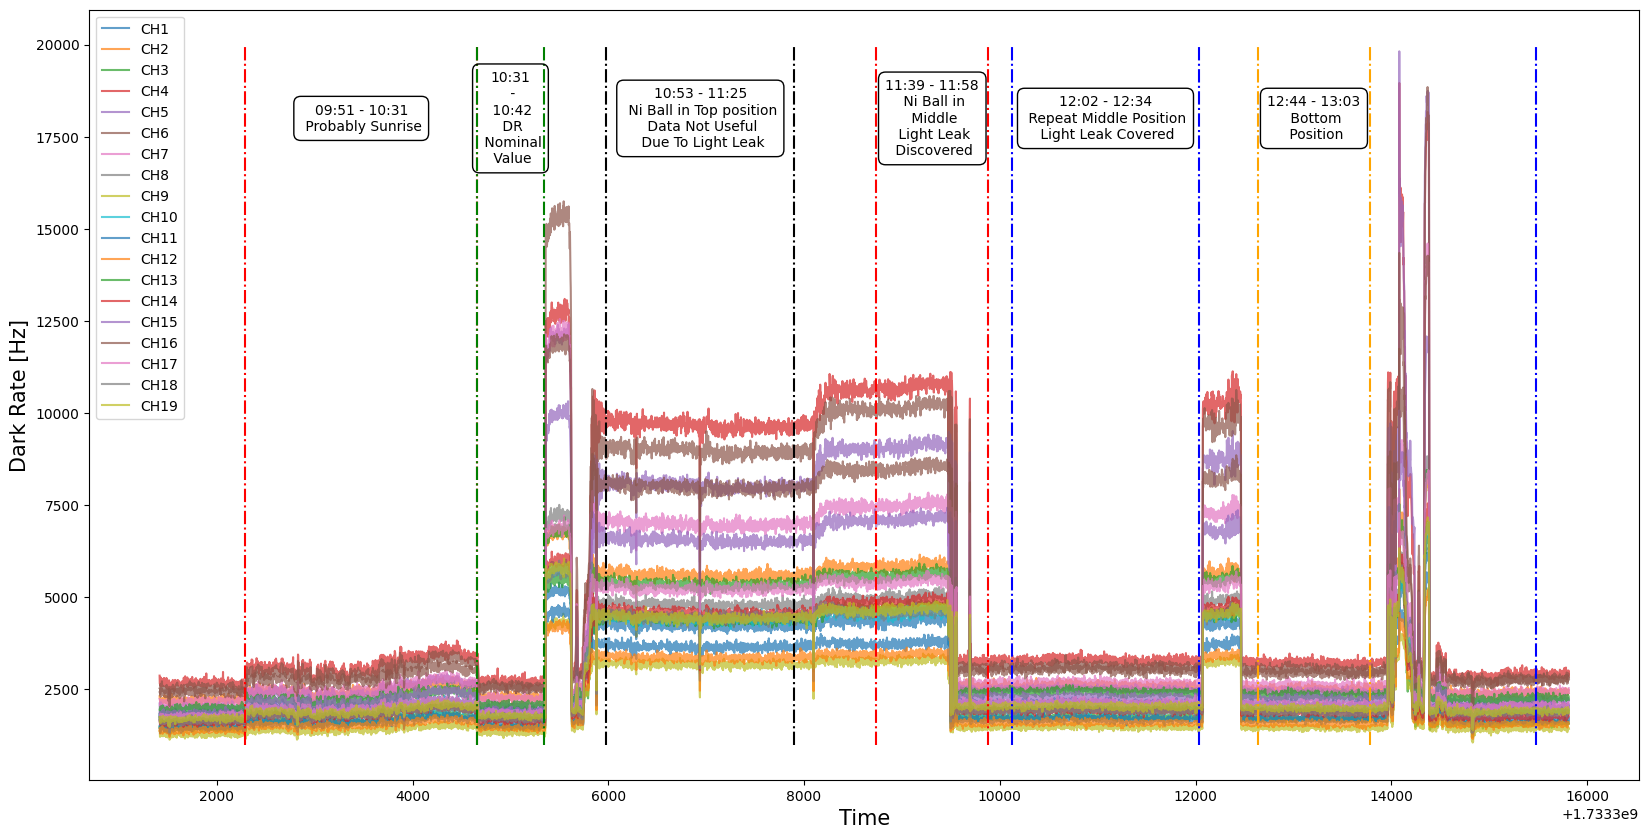

In [ ]:
import pytz
import datetime

times    = []
channels = []
for i in range(19):
    times.append(fd_df[f"Time_CH{i+1}"].values)
    channels.append(fd_df[f"CH{i+1}"].values)
    
fig = plt.figure(figsize=(20,10))
for i in range(19):
    plt.plot(times[i], channels[i], alpha=0.7, label=f"CH{i+1}");

# Top Position Data Taking
plt.vlines(CET_to_unix("04-12-2024 10:53:00"), 1e3, 20e3, linestyle="-.", color="black");
plt.vlines(CET_to_unix("04-12-2024 11:25:00"), 1e3, 20e3, linestyle="-.", color="black");
plt.text(np.mean([CET_to_unix("04-12-2024 10:53:00"), CET_to_unix("04-12-2024 11:25:00")]), 18e3, "10:53 - 11:25\n Ni Ball in Top position\n Data Not Useful\n Due To Light Leak", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='None', edgecolor='black', boxstyle='round,pad=0.5'))

# Middle Position Data Taking
plt.vlines(CET_to_unix("04-12-2024 11:39:00"), 1e3, 20e3, linestyle="-.", color="red");
plt.vlines(CET_to_unix("04-12-2024 11:58:00"), 1e3, 20e3, linestyle="-.", color="red");
plt.text(np.mean([CET_to_unix("04-12-2024 11:39:00"), CET_to_unix("04-12-2024 11:58:00")]), 18e3, "11:39 - 11:58\n Ni Ball in\n Middle\n Light Leak\n Discovered", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='None', edgecolor='black', boxstyle='round,pad=0.5'))

# Middle Position Data Taking (Repeated)
plt.vlines(CET_to_unix("04-12-2024 12:02:00"), 1e3, 20e3, linestyle="-.", color="blue");
plt.vlines(CET_to_unix("04-12-2024 12:34:00"), 1e3, 20e3, linestyle="-.", color="blue");
plt.text(np.mean([CET_to_unix("04-12-2024 12:02:00"), CET_to_unix("04-12-2024 12:34:00")]), 18e3, "12:02 - 12:34\n Repeat Middle Position\n Light Leak Covered", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='None', edgecolor='black', boxstyle='round,pad=0.5'))

# Bottom Position Data Taking
plt.vlines(CET_to_unix("04-12-2024 12:44:00"), 1e3, 20e3, linestyle="-.", color="orange");
plt.vlines(CET_to_unix("04-12-2024 13:03:00"), 1e3, 20e3, linestyle="-.", color="orange");
plt.text(np.mean([CET_to_unix("04-12-2024 12:44:00"), CET_to_unix("04-12-2024 13:03:00")]), 18e3, "12:44 - 13:03\n Bottom\n Position", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='None', edgecolor='black', boxstyle='round,pad=0.5'))


plt.vlines(CET_to_unix("04-12-2024 09:51:30"), 1e3, 20e3, linestyle="-.", color="red");
plt.vlines(CET_to_unix("04-12-2024 10:31:00"), 1e3, 20e3, linestyle="-.", color="red");
plt.text(np.mean([CET_to_unix("04-12-2024 09:51:30"), CET_to_unix("04-12-2024 10:31:00")]), 18e3, "09:51 - 10:31\n Probably Sunrise", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='None', edgecolor='black', boxstyle='round,pad=0.5'))
plt.vlines(CET_to_unix("04-12-2024 10:31:00"), 1e3, 20e3, linestyle="-.", color="green");
plt.vlines(CET_to_unix("04-12-2024 10:42:20"), 1e3, 20e3, linestyle="-.", color="green");
plt.text(np.mean([CET_to_unix("04-12-2024 10:31:00"), CET_to_unix("04-12-2024 10:42:20")]), 18e3, "10:31\n -\n 10:42\n DR\n Nominal\n Value", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='None', edgecolor='black', boxstyle='round,pad=0.5'))

plt.vlines(CET_to_unix("04-12-2024 13:31:16"), 1e3, 20e3, linestyle="-.", color="blue");

plt.xlabel("Time", fontsize=15);
plt.ylabel("Dark Rate [Hz]", fontsize=15);
#plt.grid(True)
plt.legend(loc="upper left");

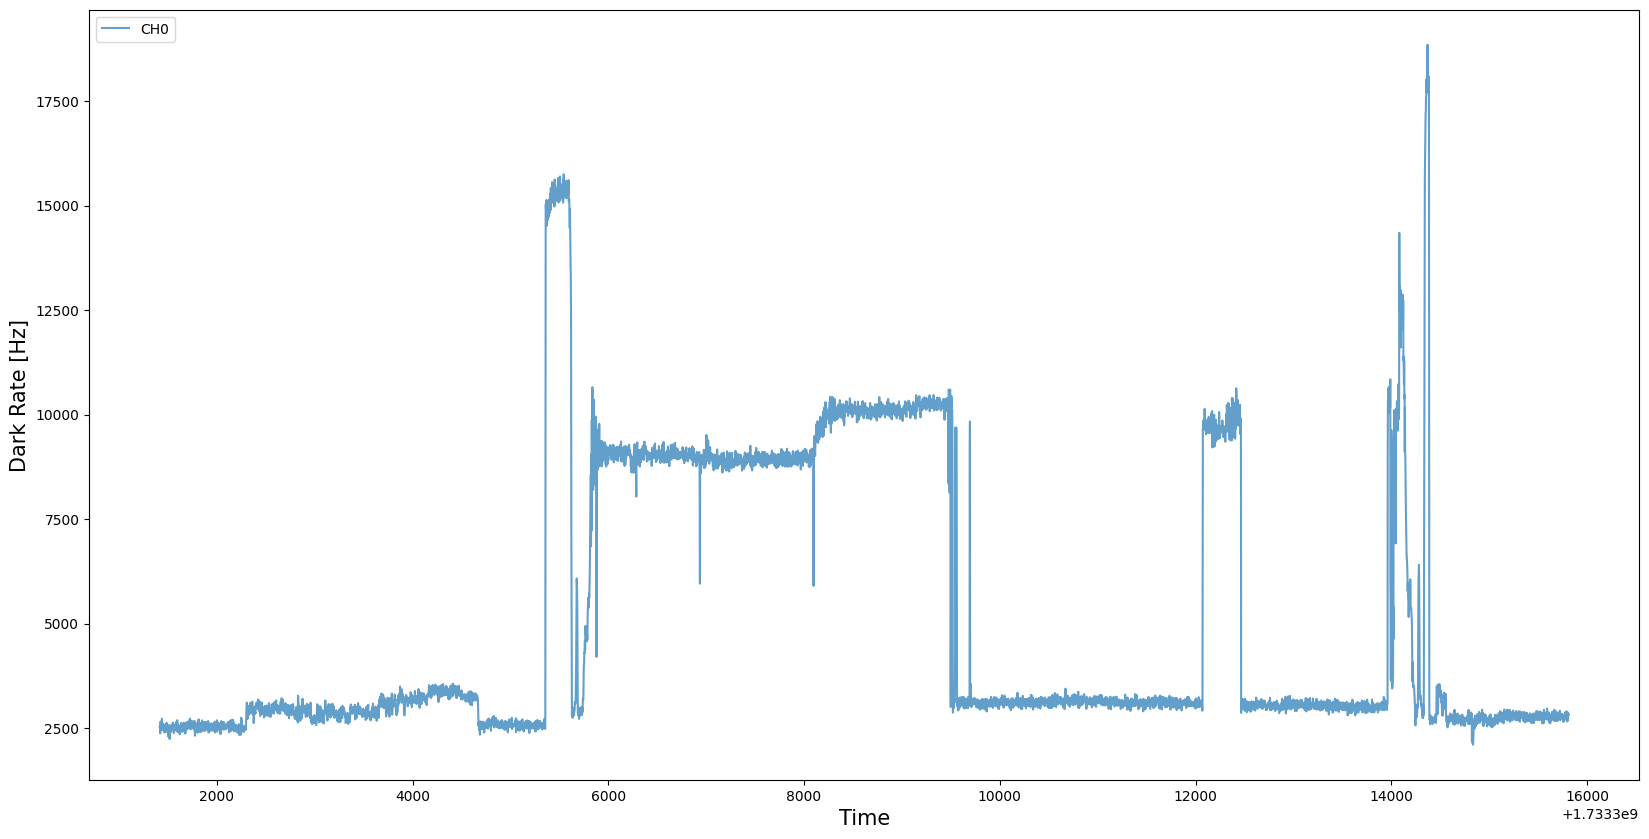

In [ ]:
pmt_channel = 5
fig = plt.figure(figsize=(20,10))
plt.plot(times[pmt_channel], channels[pmt_channel], alpha=0.7, label=f"CH0");

plt.xlabel("Time", fontsize=15);
plt.ylabel("Dark Rate [Hz]", fontsize=15);
plt.legend(loc="upper left");

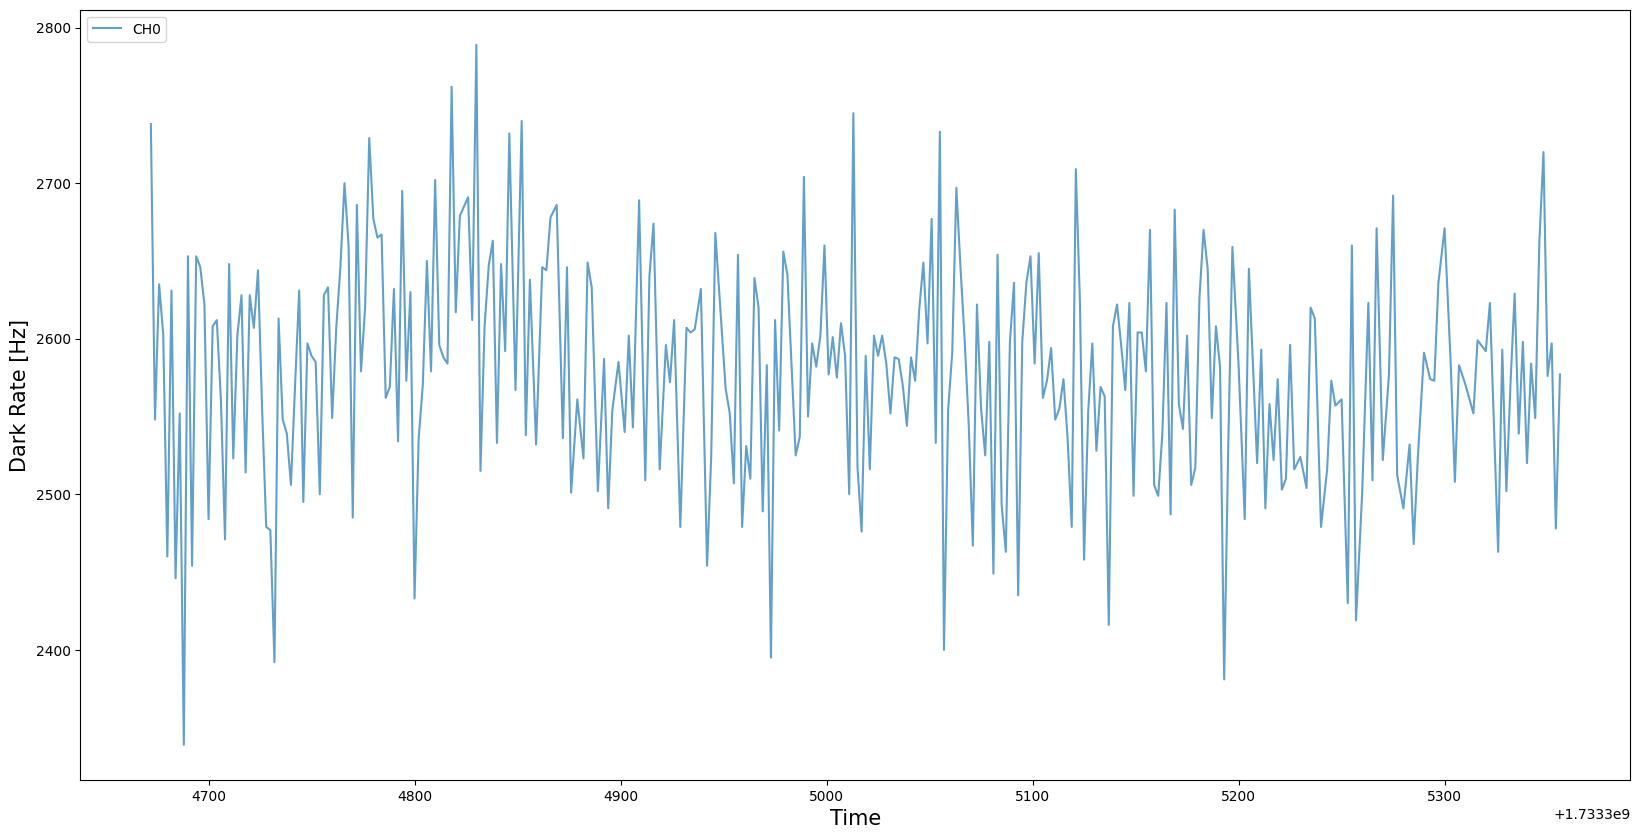

In [ ]:
fig = plt.figure(figsize=(20,10))
ri_noise = 1533
rf_noise = 1853
plt.plot(times[pmt_channel][ri_noise:rf_noise], channels[pmt_channel][ri_noise:rf_noise], alpha=0.7, label=f"CH0");

plt.xlabel("Time", fontsize=15);
plt.ylabel("Dark Rate [Hz]", fontsize=15);
plt.legend(loc="upper left");

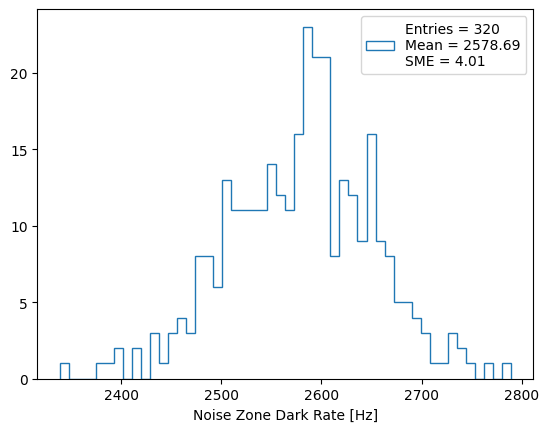

In [ ]:
data = channels[pmt_channel][ri_noise:rf_noise]

plt.hist(data, bins=50, histtype='step');
plt.xlabel("Noise Zone Dark Rate [Hz]")

entries_noise = len(data)
mean_noise = np.mean(data)
std_dev_noise = np.std(data)

# Crear la leyenda con las estadísticas
legend_text = (f'Entries = {entries_noise}\n'
               f'Mean = {mean_noise:.2f}\n'
               f'SME = {std_dev_noise/np.sqrt(entries_noise):.2f}'
               )

# Añadir la leyenda al gráfico
plt.legend([legend_text], loc='upper right');

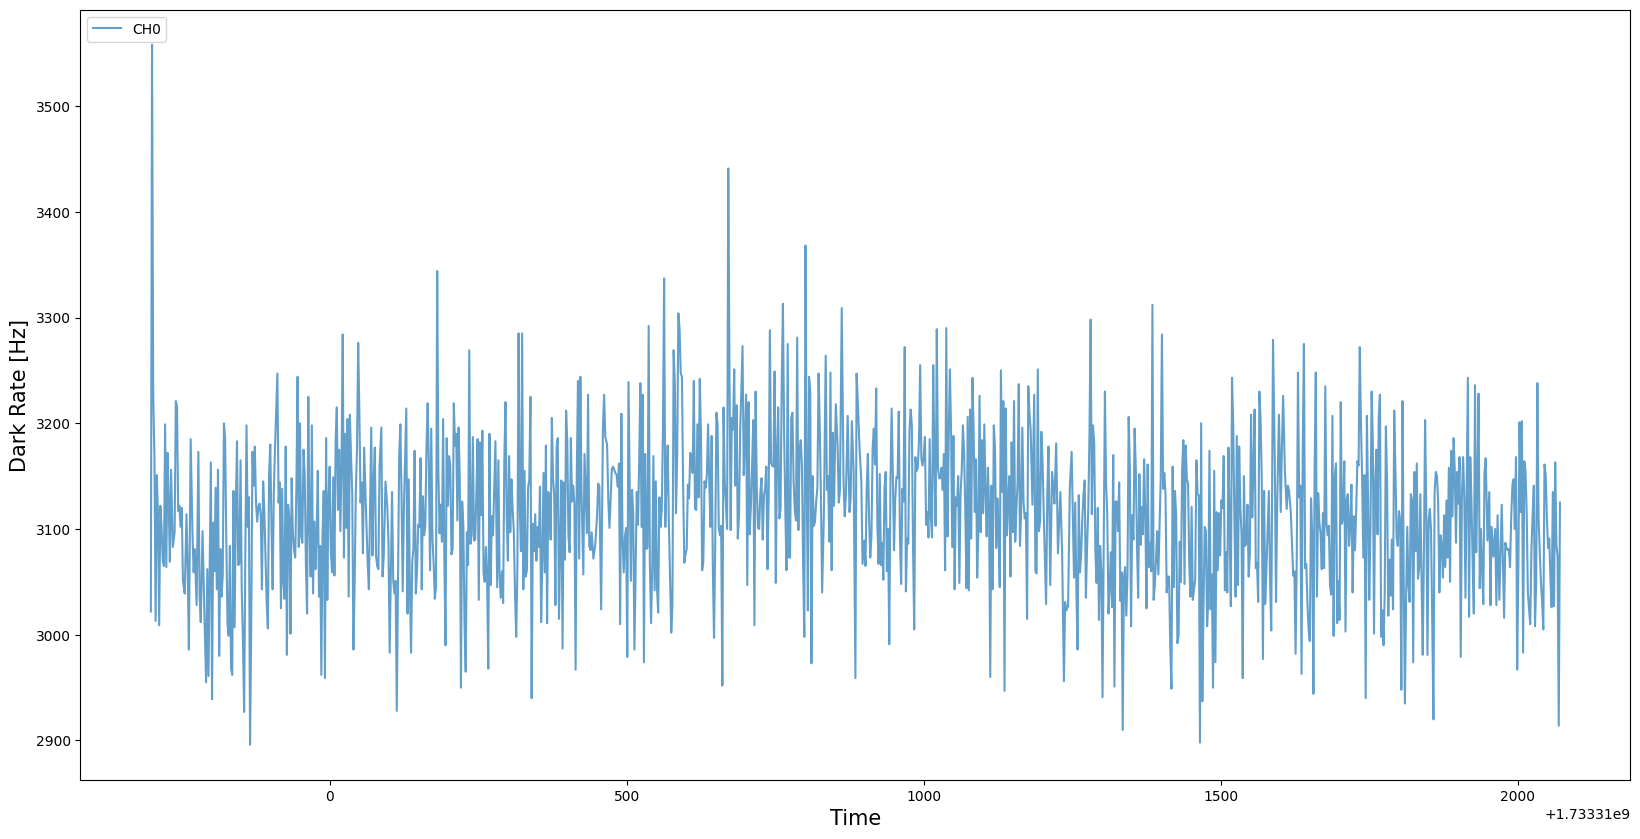

In [ ]:
fig = plt.figure(figsize=(20,10))
ri_signal = 3926
rf_signal = 5072
plt.plot(times[pmt_channel][ri_signal:rf_signal], channels[pmt_channel][ri_signal:rf_signal], alpha=0.7, label=f"CH0");

plt.xlabel("Time", fontsize=15);
plt.ylabel("Dark Rate [Hz]", fontsize=15);
plt.legend(loc="upper left");

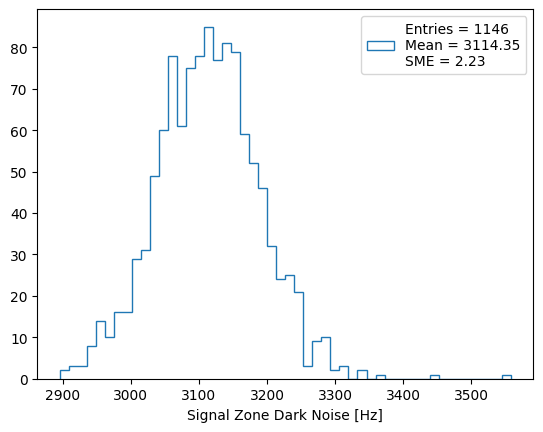

In [ ]:
data = channels[pmt_channel][ri_signal:rf_signal]

plt.hist(data, bins=50, histtype='step');
plt.xlabel("Signal Zone Dark Noise [Hz]")

entries_signal = len(data)
mean_signal = np.mean(data)
std_dev_signal = np.std(data)

# Crear la leyenda con las estadísticas
legend_text = (f'Entries = {entries_signal}\n'
               f'Mean = {mean_signal:.2f}\n'
               f'SME = {std_dev_signal/np.sqrt(entries_signal):.2f}'
               )

# Añadir la leyenda al gráfico
plt.legend([legend_text], loc='upper right');

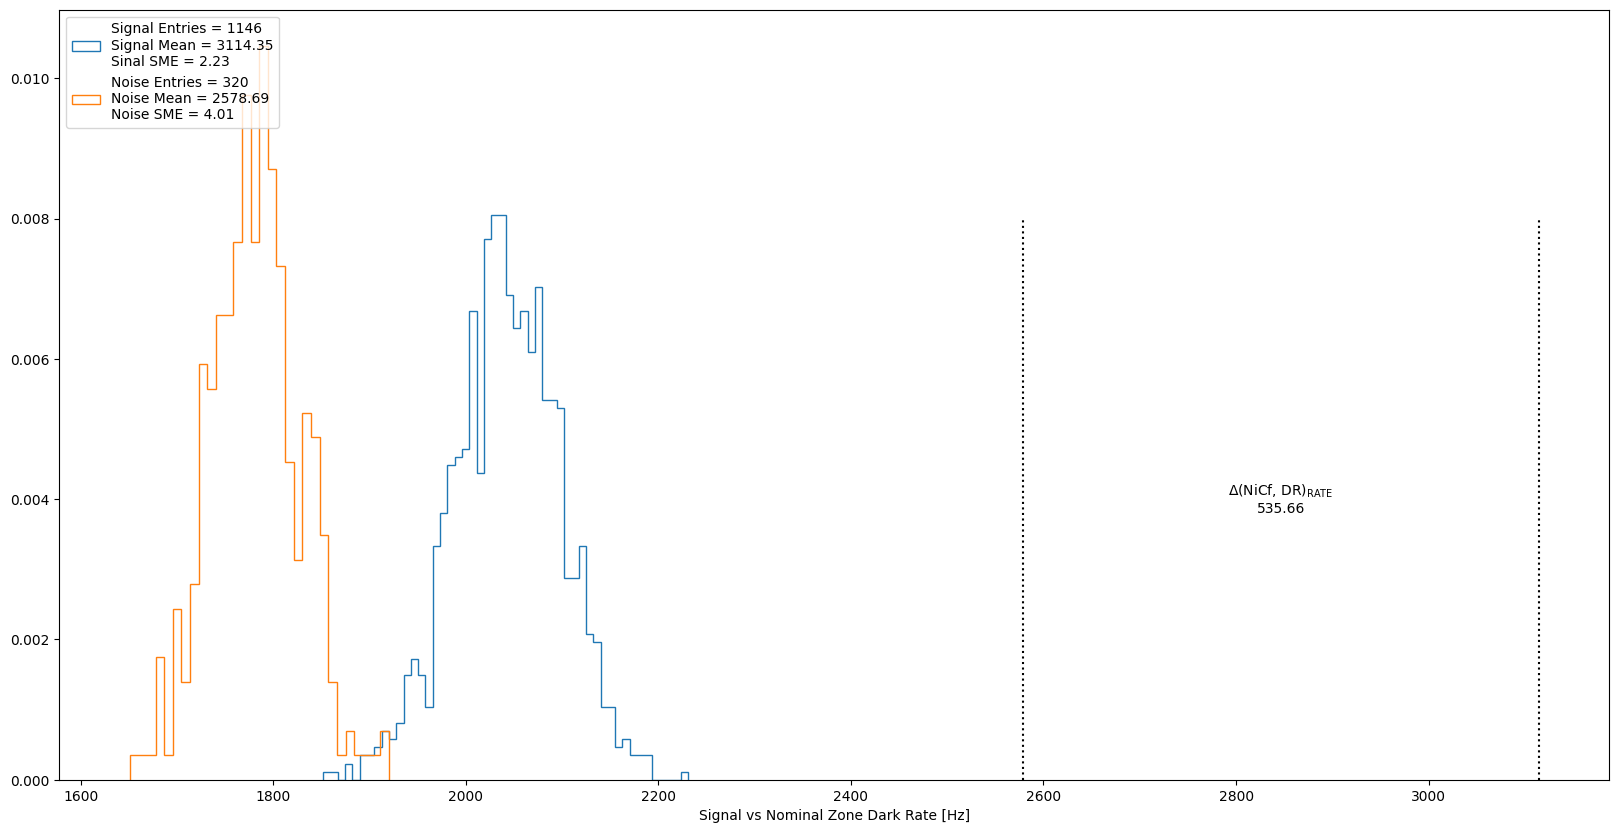

In [ ]:
fig = plt.figure(figsize=(20,10))

plt.hist(channels[pmt_channel][ri_signal:rf_signal], bins=50, histtype='step', density=True);
plt.hist(channels[pmt_channel][ri_noise:rf_noise], bins=30, histtype='step', density=True);

legend_signal = (f'Signal Entries = {entries_signal}\n'
               f'Signal Mean = {mean_signal:.2f}\n'
               f'Sinal SME = {std_dev_signal/np.sqrt(entries_signal):.2f}'
               )

legend_noise = (f'Noise Entries = {entries_noise}\n'
               f'Noise Mean = {mean_noise:.2f}\n'
               f'Noise SME = {std_dev_noise/np.sqrt(entries_noise):.2f}'
               )

# Draw Arrow
plt.vlines(mean_noise, 0, 0.008, linestyle=':', color='black');
plt.vlines(mean_signal, 0, 0.008, linestyle=':', color='black');

plt.text(np.mean([mean_noise, mean_signal]), 0.004, r"$\Delta$(NiCf, DR)$_{\mathrm{RATE}}$" + f"\n{mean_signal-mean_noise:.2f}", horizontalalignment='center', verticalalignment='center')


# Añadir la leyenda al gráfico
plt.legend([legend_signal, legend_noise], loc='upper left');

plt.xlabel("Signal vs Nominal Zone Dark Rate [Hz]");

In [ ]:
ri_noise = 1533
rf_noise = 1853
ri_signal = 3926
rf_signal = 5072

difference_in_rate = []

for i in range(19):
    signall = np.mean(channels[i][ri_signal:rf_signal])
    noisee  = np.mean(channels[i][ri_noise:rf_noise])
    
    difference_in_rate.append(signall-noisee)

In [ ]:
difference_in_rate

[201.75462478184977,
 300.421269633508,
 262.69612238219884,
 563.9626745200699,
 453.13235165794094,
 535.6641579406632,
 431.36016579406623,
 289.1810591186736,
 153.69327552356026,
 184.8801428883071,
 148.85430846422332,
 139.64880562827216,
 338.2027214223385,
 263.8262216404885,
 388.45144524432794,
 480.03135907504384,
 269.71581042757407,
 219.77190226876087,
 262.04321553228624]

In [ ]:
np.mean(difference_in_rate)

309.8574544181133

## For Sets Of Proper Noise

In [ ]:
noisy_times    = []
noisy_channels = []
for i in range(19):
    noisy_times.append(noise[f"Time_CH{i+1}"].values)
    noisy_channels.append(noise[f"CH{i+1}"].values)

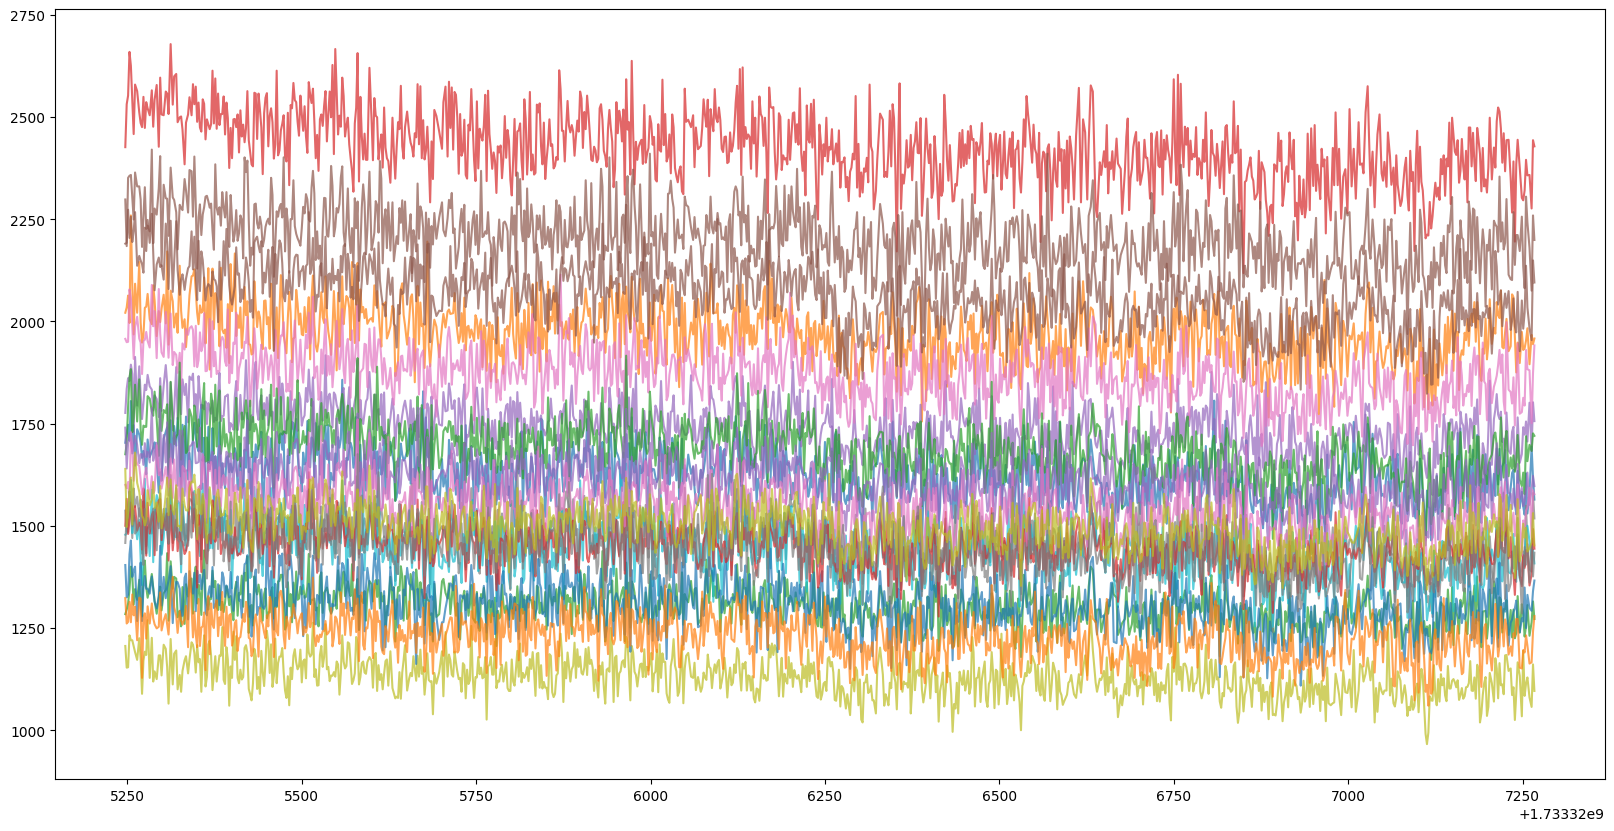

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(19):
    plt.plot(noisy_times[i], noisy_channels[i], alpha=0.7, label=f"CH{i+1}");
    
#plt.vlines(CET_to_unix("04-12-2024 16:30:00"), 1e3, 2.5e3, linestyle="-.", color="blue");
#plt.vlines(CET_to_unix("04-12-2024 08:57:14"), 1e3, 2.5e3, linestyle="-.", color="blue");

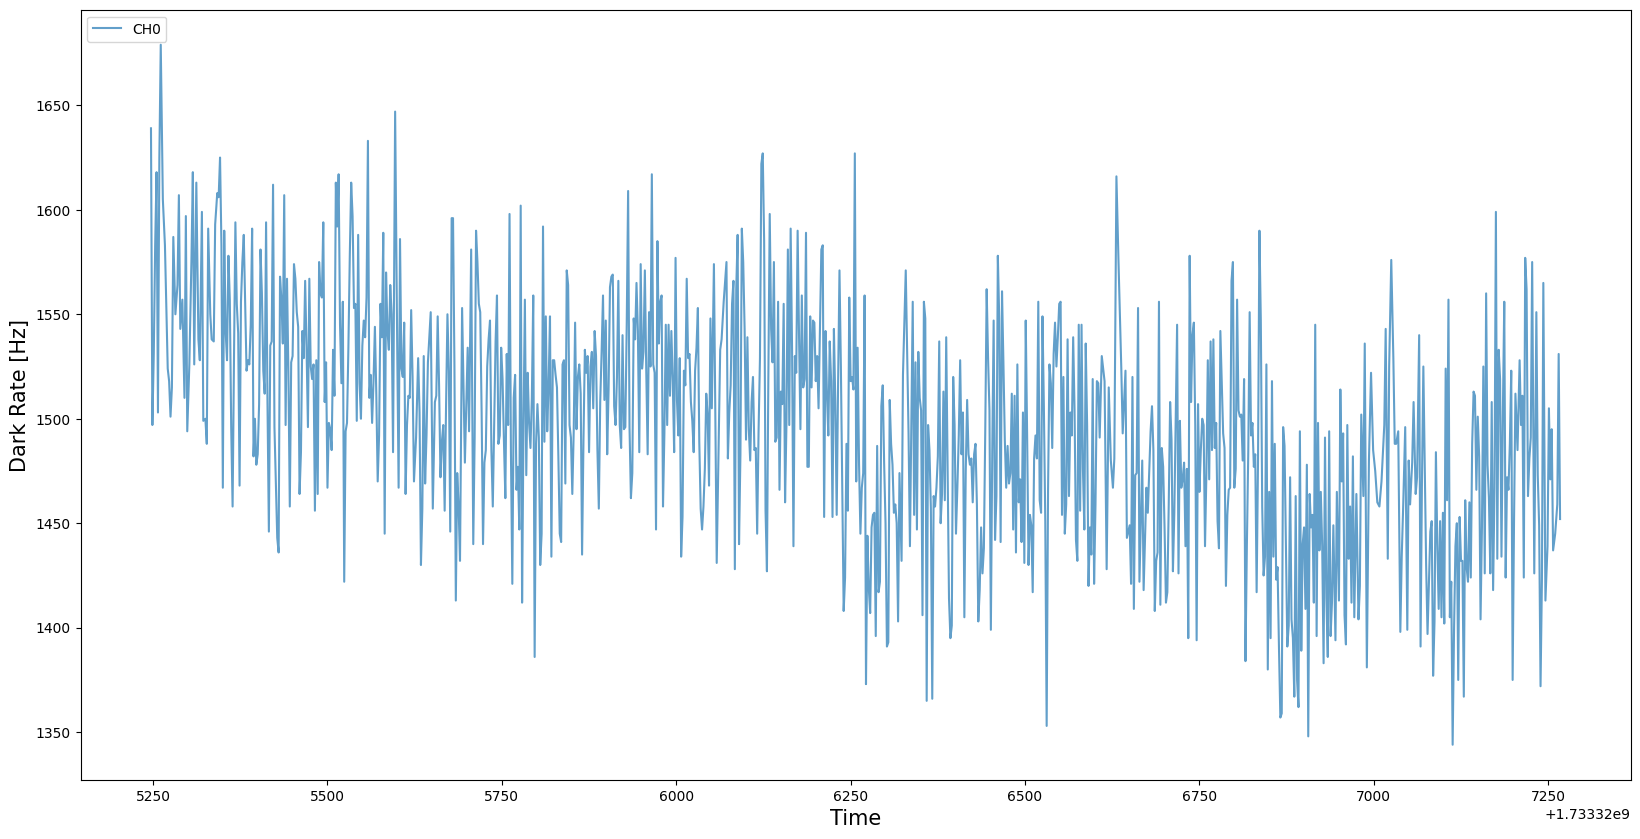

In [ ]:
pmt_channel = 18
fig = plt.figure(figsize=(20,10))
plt.plot(noisy_times[pmt_channel], noisy_channels[pmt_channel], alpha=0.7, label=f"CH0");

plt.xlabel("Time", fontsize=15);
plt.ylabel("Dark Rate [Hz]", fontsize=15);
plt.legend(loc="upper left");

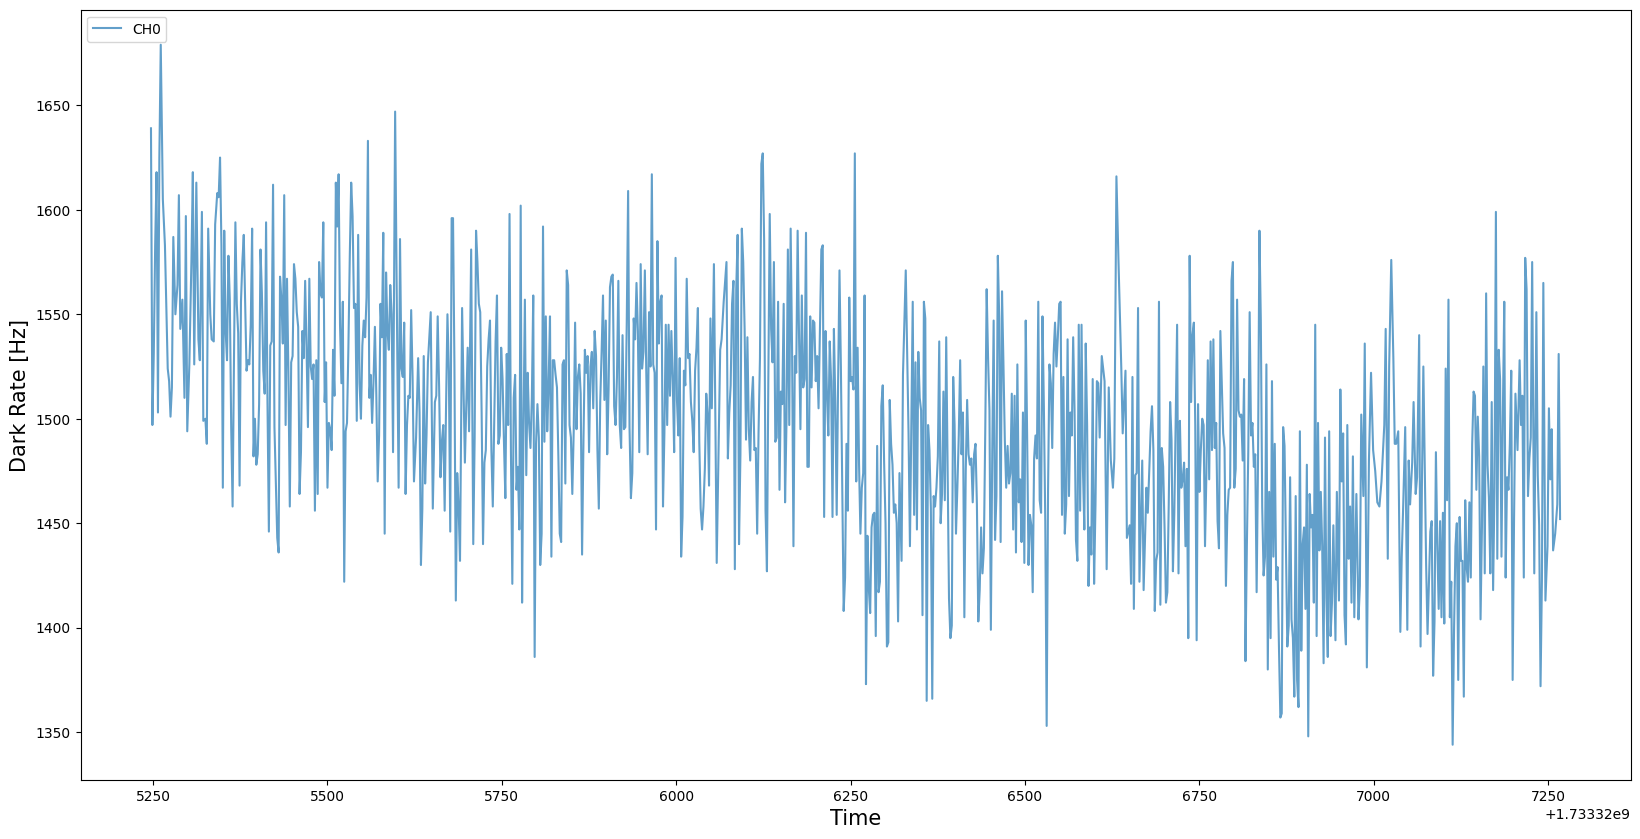

In [ ]:
fig = plt.figure(figsize=(20,10))
ri_noisy = 0
rf_noisy = 19600
plt.plot(noisy_times[pmt_channel][:], noisy_channels[pmt_channel][:], alpha=0.7, label=f"CH0");

plt.xlabel("Time", fontsize=15);
plt.ylabel("Dark Rate [Hz]", fontsize=15);
plt.legend(loc="upper left");

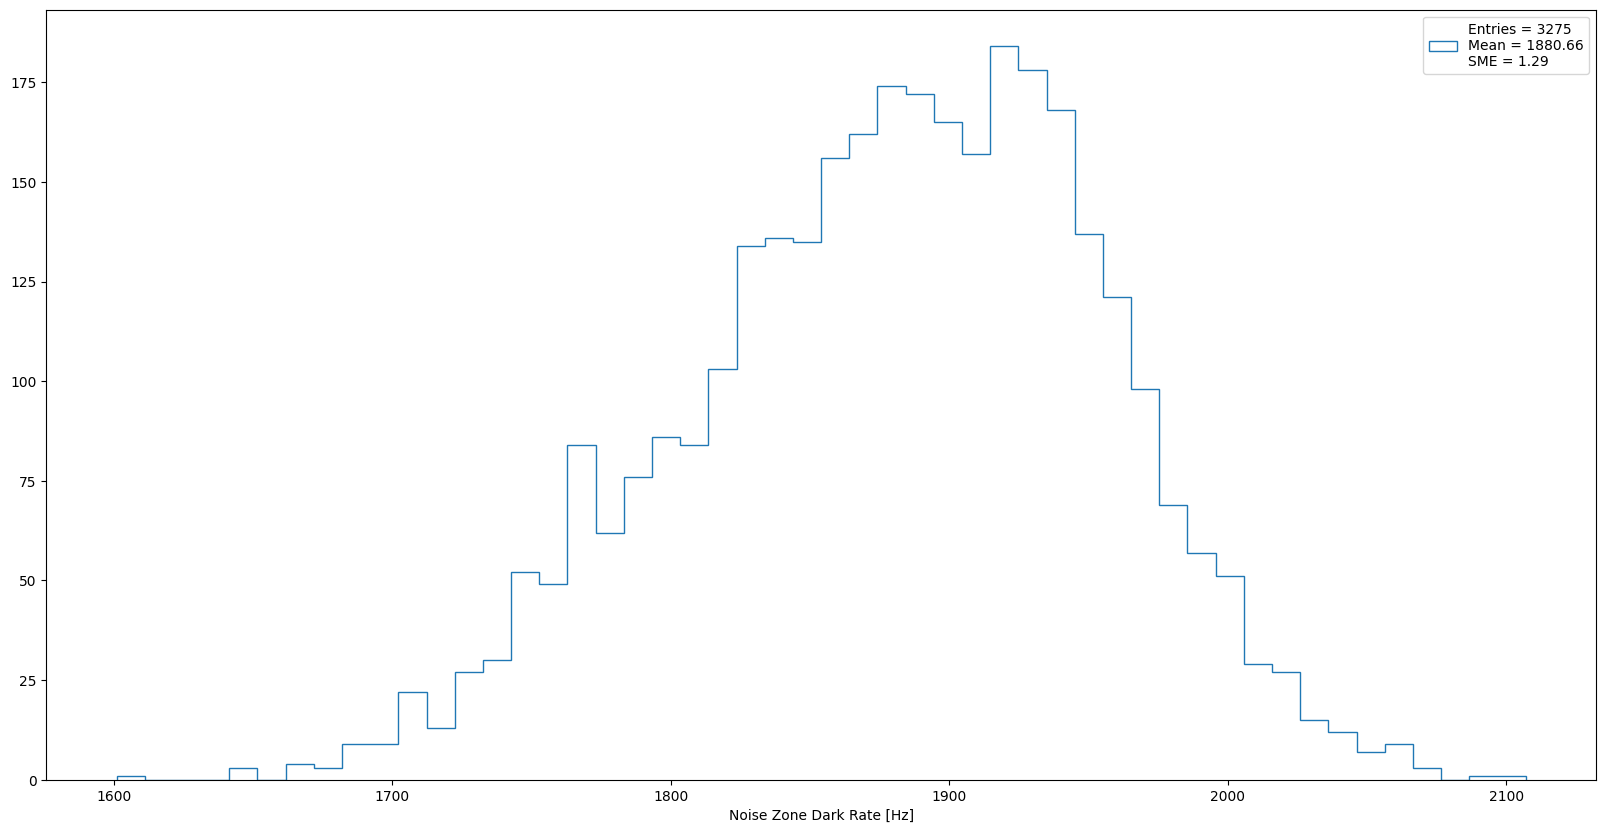

In [ ]:
fig = plt.figure(figsize=(20,10))

data = noisy_channels[pmt_channel][:]

plt.hist(data, bins=50, histtype='step');
plt.xlabel("Noise Zone Dark Rate [Hz]")

entries_noisy_noise = len(data)
mean_noisy_noise = np.mean(data)
std_dev_noisy_noise = np.std(data)

# Crear la leyenda con las estadísticas
legend_text = (f'Entries = {entries_noisy_noise}\n'
               f'Mean = {mean_noisy_noise:.2f}\n'
               f'SME = {std_dev_noisy_noise/np.sqrt(entries_noisy_noise):.2f}'
               )

# Añadir la leyenda al gráfico
plt.legend([legend_text], loc='upper right');

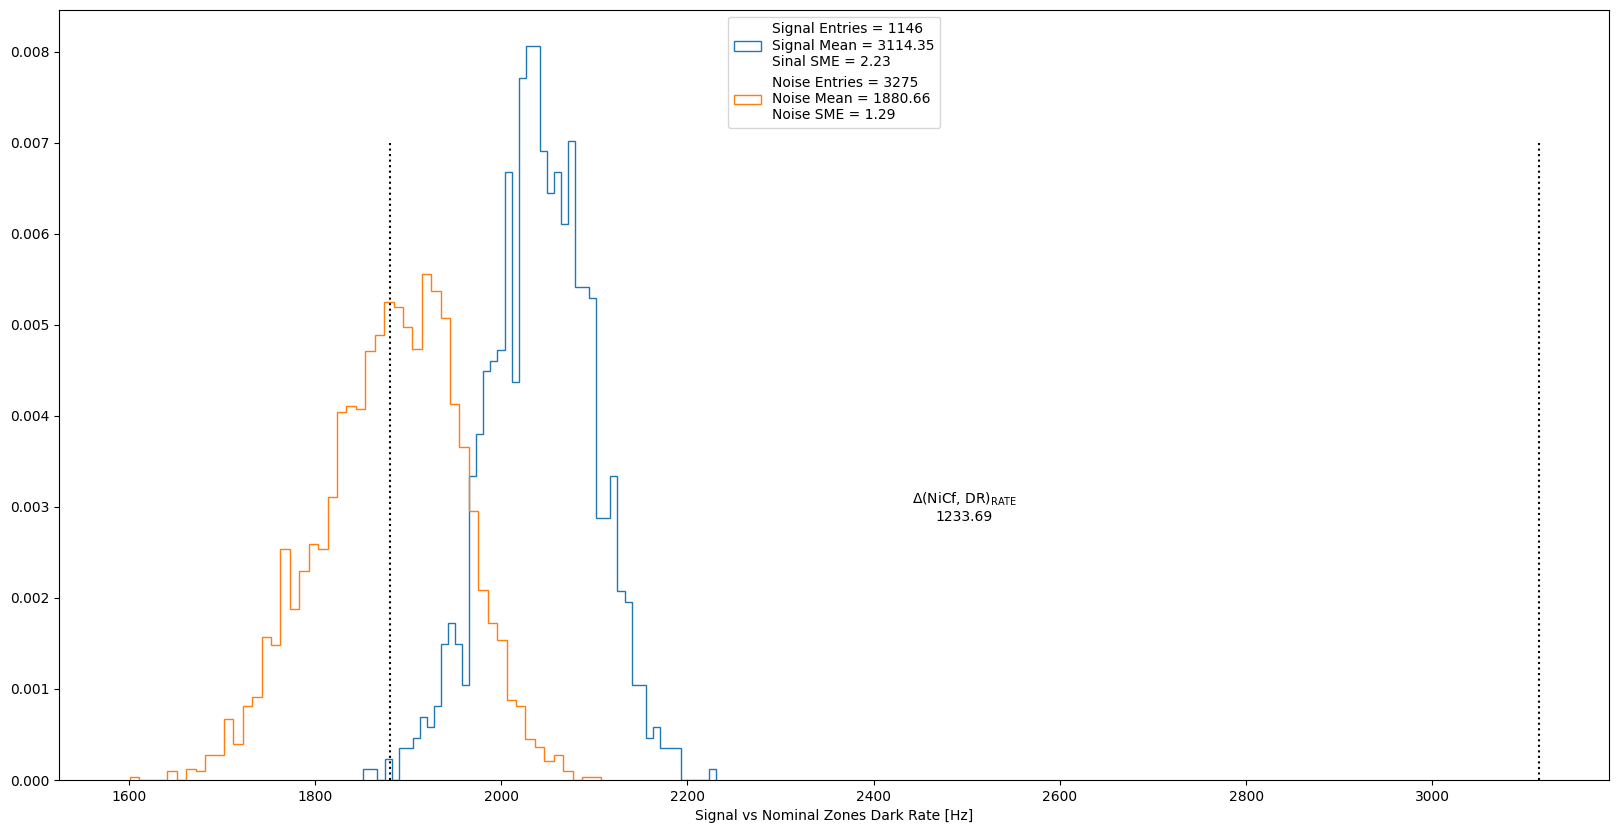

In [ ]:
fig = plt.figure(figsize=(20,10))

plt.hist(channels[pmt_channel][ri_signal:rf_signal], bins=50, histtype='step', density=True);
plt.hist(noisy_channels[pmt_channel][:], bins=50, histtype='step', density=True);

legend_signal = (f'Signal Entries = {entries_signal}\n'
               f'Signal Mean = {mean_signal:.2f}\n'
               f'Sinal SME = {std_dev_signal/np.sqrt(entries_signal):.2f}'
               )

legend_noisy_noise = (f'Noise Entries = {entries_noisy_noise}\n'
               f'Noise Mean = {mean_noisy_noise:.2f}\n'
               f'Noise SME = {std_dev_noisy_noise/np.sqrt(entries_noisy_noise):.2f}'
               )

# Draw Arrow
plt.vlines(mean_noisy_noise, 0, 0.007, linestyle=':', color='black');
plt.vlines(mean_signal, 0, 0.007, linestyle=':', color='black');

plt.text(np.mean([mean_noisy_noise, mean_signal]), 0.003, r"$\Delta$(NiCf, DR)$_{\mathrm{RATE}}$" + f"\n{mean_signal-mean_noisy_noise:.2f}", horizontalalignment='center', verticalalignment='center')


# Añadir la leyenda al gráfico
plt.legend([legend_signal, legend_noisy_noise], loc='upper center');

plt.xlabel("Signal vs Nominal Zones Dark Rate [Hz]");

In [ ]:
ri_signal = 3926
rf_signal = 5072

difference_in_rate = []

for i in range(19):
    signall = np.mean(channels[i][ri_signal:rf_signal])
    noisee  = np.mean(noisy_channels[i][:])
    
    difference_in_rate.append(signall-noisee)

In [ ]:
difference_in_rate

[487.50348133070634,
 620.3914619412003,
 449.28294020964177,
 863.5870768069722,
 759.6323776454667,
 907.3641319531371,
 811.1057479146484,
 590.0607173827068,
 352.29954501420457,
 484.2332419007812,
 386.77386407752897,
 363.9324269900185,
 732.4903578568501,
 478.16255220181915,
 669.0484501819578,
 961.6169230043579,
 588.7643616230005,
 501.3735654704242,
 545.9752061767767]

In [ ]:
np.mean(difference_in_rate)

608.0841278780105

In [ ]:
np.mean(difference_in_rate)

198.84304953663482